In [1]:
# This program is developed by Sorush Omidvar to process the dataset collected at Texas A&M University May 2022
# This cell imports the required library and set some parameters to configure the code
from datetime import datetime, timedelta, timezone
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr, mode, skew, kurtosis, linregress
import xgboost as xgb
from joblib import Parallel, delayed
import sklearn
import pickle
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, recall_score, precision_score, accuracy_score, precision_recall_curve, auc, f1_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, ShuffleSplit, StratifiedKFold, KFold
from imblearn.over_sampling import SMOTE
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import mean_squared_error as MSE
import zipfile
import warnings
import seaborn as sns
import joblib
from scipy import signal
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import multiprocessing as mp
from matplotlib import patches
import sys
import shap
import neurokit2 as nk
os.nice(10)

# For plotting the seaborn with latex
# sns.set_style("white")
# plt.rcParams["text.usetex"] = True
# font = {"family": "normal", "weight": "bold", "size": 16}
font = {"family": "normal", "size": 14}
plt.rc("font", **font)

# Considering the existing lag in Apple Watch data (partially the day-light saving), this value aligns the timming of the apple watch to Texas Central time.
MOTION_LAG_CORRECTION = [
    ("p1", timedelta(minutes=2 * 60 + 36)),
    ("p3", timedelta(minutes=2 * 60)),
    ("p5", timedelta(minutes=-360)),
    ("p6", timedelta(minutes=-360)),
    ("p7", timedelta(minutes=-360)),
    ("p8", timedelta(minutes=-360)),
    # ("p8", datetime.strptime("02 02 2022-00:00:00", "%m %d %Y-%H:%M:%S"),datetime.strptime("02 06 2022-07:20:00", "%m %d %Y-%H:%M:%S"),timedelta(minutes=-165)),
    # ("p8", datetime.strptime("02 06 2022-07:20:00", "%m %d %Y-%H:%M:%S"),datetime.strptime("02 09 2022-00:00:00", "%m %d %Y-%H:%M:%S"),timedelta(minutes=-165-190)),
    # ("p8", datetime.strptime("02 09 2022-07:20:00", "%m %d %Y-%H:%M:%S"),datetime.strptime("02 14 2022-00:00:00", "%m %d %Y-%H:%M:%S"),timedelta(minutes=93)),
]
# CGM_LAG_IMPOSING_STR = sys.argv[1]# ONLY TO IMPOSE A TIME LAG BETWEEN CGM READINGS AND CORE MOTION DATA!!!! WATCH OUT AND USE IT CAUTIOUSLY
CGM_LAG_IMPOSING_STR = "0"  # This value can be used to lag the CGM response forward or backward to handle the fact that PPGR is not instantaneous so use it cautiously
CGM_LAG_IMPOSING = timedelta(minutes=int(CGM_LAG_IMPOSING_STR))
AVERAGING_BLOCK = timedelta(minutes=5)  # Averaging the results of detection performed by XGBoost. So, if we are using the window of 30 seconds and average over 5 minutes, we can remove false postivies/negatives by voting.

OUTTER_WINDOW_LENGTH = timedelta(minutes=30)  # Length of CGM window
INNER_WINDOW_LENGTH = timedelta(seconds=30)  # Length of Apple Watch, E4 window
OUTTER_WINDOW_STEP = timedelta(seconds=30)  # Step of windows

# OUTTER_WINDOW_LENGTH = timedelta(minutes=int(sys.argv[1]))
# OUTTER_WINDOW_STEP = timedelta(seconds=int(sys.argv[2]))
# INNER_WINDOW_LENGTH = timedelta(seconds=int(sys.argv[2]))
# print("Outter Step:", str(OUTTER_WINDOW_STEP), "Inner Length:", str(INNER_WINDOW_LENGTH))

EDA_FLAG = "TOTAL"  # TOTAL, TONIC, PHASIC for EDA
FASTING_LENGTH = timedelta(minutes=30)  # This option is not used during the code but left here
BIG_MEAL_CALORIE = 200  # This option is not used during the code but left here
COMPLEX_MEAL_DURATION = timedelta(minutes=60)  # This option is not used during the code but left here
FOLD_NUMBER = 5  # Fold number for eating detection as we are using k-fold (NOT-STRATIFIED)
MINIMUM_POINT = INNER_WINDOW_LENGTH.total_seconds()  # This will be used toward the minimum points required for sensor readings


START_OF_TRIAL = [datetime.strptime("11 06 2021-04:00:00", "%m %d %Y-%H:%M:%S"), datetime.strptime("02 03 2022-00:00:00", "%m %d %Y-%H:%M:%S")]  # Each round has a start date (2 rounds and 2 start dates)
END_OF_TRIAL = [datetime.strptime("11 15 2021-00:00:00", "%m %d %Y-%H:%M:%S"), datetime.strptime("02 13 2022-00:00:00", "%m %d %Y-%H:%M:%S")]  # Each round has a end date (2 rounds and 2 end dates)
DAY_LIGHT_SAVING = datetime.strptime("11 06 2021-02:00:00", "%m %d %Y-%H:%M:%S")  # Date at which day-light saving comes in place
coreNumber = 24  # Number of cores for parallel processing.

addDataPrefix = "/Users/sorush/My Drive/Documents/Educational/TAMU/Research/TAMU/"  # Result folder
if not os.path.exists(addDataPrefix):
    addDataPrefix = "/home/grads/s/sorush.omidvar/CGMDataset/TAMU/"

addUserInput = os.path.join(addDataPrefix, "User inputted")  # Input directory for Apple watch user diary
addHKMotion = os.path.join(addDataPrefix, "hk+cm")  # Input directory for healthkit and core motion Apple Watch data
addCGM = os.path.join(addDataPrefix, "CGM")  # Input directory for CGM data
addE4 = os.path.join(addDataPrefix, "E4")  # Input directory for Empatica E4 data
addResults = os.path.join(addDataPrefix, "Results" + str(CGM_LAG_IMPOSING_STR))  # Result address based on the CGM_Lag time defined earlier
if not os.path.exists(addResults):
    os.mkdir(addResults)

exempts = ["p2", "p4"]  # Discarded users


pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({"figure.facecolor": "white"})
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # no GPU
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 200)


/home/grads/s/sorush.omidvar/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [6]:
##This cell unzips the E4 data from zip files.
# def unzipperE4(participantFolder):
#     for root, dirs, files in os.walk(participantFolder):
#         for file in files:
#             if not '.zip' in file:
#                 continue
#             with zipfile.ZipFile(os.path.join(root,file), 'r') as zip_ref:
#                 destFile=file[:file.find('.zip')]
#                 destFile=os.path.join(root,destFile)
#                 if not os.path.exists(destFile):
#                     os.mkdir(destFile)
#                 zip_ref.extractall(destFile)
# def zipCleanerE4(E4Folder):
#     for root, dirs, files in os.walk(E4Folder):
#         for file in files:
#             if '.zip' in file:
#                 os.remove(os.path.join(root,file))

# unzipperE4('/Users/sorush/Desktop/Round2E4/p5')
# unzipperE4('/Users/sorush/Desktop/Round2E4/p6')
# unzipperE4('/Users/sorush/Desktop/Round2E4/p7')
# unzipperE4('/Users/sorush/Desktop/Round2E4/p8')
# zipCleanerE4('/Users/sorush/Desktop/Round2E4')


In [7]:
# This cell forms the dfMeal which contains all the info for participants' meals (time and content)
def trialTimeLimitter(df, columnName):  # Limiting the dataframe to the trial date ranges defined in START_OF_TRIAL and END_OF_TRIAL
    participants = list(set(df["Participant"].to_list()))
    dfTotal = []
    for participant in participants:
        if participant == "p1" or participant == "p2" or participant == "p3" or participant == "p4":
            startOfTrial = START_OF_TRIAL[0]
            endOfTrial = END_OF_TRIAL[0]
        elif participant == "p5" or participant == "p6" or participant == "p7" or participant == "p8":
            startOfTrial = START_OF_TRIAL[1]
            endOfTrial = END_OF_TRIAL[1]
        else:
            print("Mayday in trialTimeLimitter")
            print(participant)
            raise
        dfTemp = df[df["Participant"] == participant]
        dfTemp = dfTemp[(dfTemp[columnName] >= startOfTrial) & (dfTemp[columnName] <= endOfTrial)]
        if len(dfTotal) == 0:
            dfTotal = dfTemp
        else:
            frames = [dfTotal, dfTemp]
            dfTotal = pd.concat(frames)
    return dfTotal


def mealMarker(df):  # Marking the meal (big and complex) which are not used later on
    df.insert(len(df.columns), "BigMeal", False)
    for counter in range(0, len(df)):
        if df["Calories"].iloc[counter] >= BIG_MEAL_CALORIE:
            df["BigMeal"].iloc[counter] = True

    df.insert(len(df.columns), "ComplexMeal", False)
    participants = df["Participant"].to_list()
    participants = list(set(participants))
    for participant in participants:
        dfTemp = df[df["Participant"] == participant]
        for counter in range(1, len(dfTemp)):
            if dfTemp["StartTime"].iloc[counter - 1] + COMPLEX_MEAL_DURATION >= dfTemp["StartTime"].iloc[counter]:
                dfTemp["ComplexMeal"].iloc[counter] = True
                dfTemp["ComplexMeal"].iloc[counter - 1] = True
        indexs = dfTemp.index[dfTemp["ComplexMeal"] == True]
        df["ComplexMeal"][indexs] = True
    return df


def dfMealReader():  # Reading the participants' diaries and forming dfMeal
    os.chdir(addUserInput)
    dfMeal = []
    for root, dirs, files in os.walk(addUserInput):
        print(root)
        for file in files:
            if ".csv" in file.lower():
                if "meals" in file.lower() and "modified" not in file.lower():
                    participantName = file[: file.find("Meals")]
                    if participantName in exempts:
                        print("Exemption...", file)
                        continue
                    print("Reading ...", file)
                    dfTemp = pd.read_csv(file)
                    dfTemp.insert(0, "Participant", participantName)
                    dfTemp.rename(columns={"startTime": "StartTime"}, inplace=True)
                    dfTemp["StartTime"] = pd.to_datetime(dfTemp["StartTime"])
                    dfTemp["FinishTime"] = pd.to_datetime(dfTemp["FinishTime"])
                    dfTemp.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
                    dfTemp.reset_index(drop=True, inplace=True)

                    if len(dfMeal) != 0:
                        frames = [dfTemp, dfMeal]
                        dfMeal = pd.concat(frames)
                    else:
                        dfMeal = dfTemp
    print("reading is done")
    dfMeal = trialTimeLimitter(dfMeal, "StartTime")
    dfMeal = trialTimeLimitter(dfMeal, "FinishTime")
    dfMeal.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
    dfMeal.reset_index(drop=True, inplace=True)
    # dfMeal.insert(4, "MealDuration", -1)
    # dfMeal["MealDuration"] = dfMeal["FinishTime"] - dfMeal["StartTime"]
    # dfMeal["MealDuration"] = dfMeal["MealDuration"].dt.total_seconds()
    print("Meal database is limited to the trial period")
    dfMeal.to_pickle(os.path.join(addResults, "All_meals.pkl"))
    return dfMeal


dfMeal = dfMealReader()


/home/grads/s/sorush.omidvar/CGMDataset/TAMU/User inputted
Reading ... p1Meals.csv
Reading ... p5Meals.csv
Reading ... p7Meals.csv
Reading ... p8Meals.csv
Reading ... p6Meals.csv
Reading ... p3Meals.csv
Exemption... p4Meals.csv
reading is done
Meal database is limited to the trial period


In [8]:
def timeZoneFixer(df, LocalizeFlag, columnName):  # Fixing the time zone for wearables and CGM. It fixes the daylight based on the date.
    if LocalizeFlag:
        df[columnName] -= timedelta(hours=5)
    tempColumn = df[columnName]
    tempColumn[tempColumn >= DAY_LIGHT_SAVING] -= timedelta(hours=1)
    df[columnName] = tempColumn
    return df


def pdInterpolation(dfTemp):  # Interpolating the Abbot from 15 min resolution to 1-min
    index = dfTemp["Time"]
    seriesParticipant = pd.Series(dfTemp["Abbot"].to_list(), index=index)
    seriesParticipant = seriesParticipant.resample("1T").asfreq()
    seriesParticipant.interpolate(method="polynomial", order=3, inplace=True)
    tempTime = seriesParticipant.index
    tempVal = seriesParticipant.values
    dfTemp = pd.DataFrame(zip(tempTime, tempVal), columns=["Time", "Abbot"])
    return dfTemp


def motionLagCorrector(df):  # Fix the Apple Watch lag based on MOTION_LAG_CORRECTION defined earlier for each participant
    participants = df["Participant"].to_list()
    participants = list(set(participants))
    dfTotal = []

    for element in MOTION_LAG_CORRECTION:
        participant = element[0]
        timeLag = element[1]
        dfParticipant = df[df["Participant"] == participant]
        if len(dfParticipant) == 0:
            continue
        dfParticipant["Time"] += timeLag
        if len(dfTotal) == 0:
            dfTotal = dfParticipant
        else:
            frames = [dfTotal, dfParticipant]
            dfTotal = pd.concat(frames)

    return dfTotal


def motionSmoother(df):  # Smoothing the Apple Watch data using an exponential mov-mean
    columnLabels = df.columns
    for columnLabel in columnLabels:
        if columnLabel == "Time":
            continue
        tempSerie = df[columnLabel]
        tempSerie = tempSerie.ewm(span=10).mean()  # Considering the frequency of 10 Hz
        df[columnLabel] = tempSerie
    return df


def CGMLagImposer(df):  # If there is a lag imposing to CGM
    df["Time"] += CGM_LAG_IMPOSING
    return df


def CGMNormalizer(df):  # Normalizing CGM using min/max or mean/std
    participants = list(set(df["Participant"].to_list()))
    participants.sort()
    dfResult = []
    for participant in participants:
        dfParticipant = df[df["Participant"] == participant]
        dates = list(set(dfParticipant["Time"].dt.date.to_list()))
        dates.sort()
        for date in dates:
            dfDate = dfParticipant[dfParticipant["Time"].dt.date == date]
            if len(dfDate) <= 10:
                continue
            minBG = dfDate["Abbot"].min()
            maxBG = dfDate["Abbot"].max()

            meanBG = dfDate["Abbot"].mean()
            stdBG = dfDate["Abbot"].std()
            dfDate["Abbot"] -= minBG
            dfDate["Abbot"] /= maxBG - minBG
            # dfDate["Abbot"] -= meanBG
            # dfDate["Abbot"] /= stdBG

            assert not np.isnan(minBG)
            assert not np.isnan(maxBG)
            assert not np.isnan(meanBG)
            assert not np.isnan(stdBG)
            if len(dfResult) == 0:
                dfResult = dfDate.copy()
            else:
                frames = [dfResult, dfDate]
                dfResult = pd.concat(frames)
    return dfResult


def CGMLowPass(df):  # Filter the CGM using low-pass
    participants = list(set(df["Participant"].to_list()))
    participants.sort()
    dfResult = []
    for participant in participants:
        dfParticipant = df[df["Participant"] == participant]
        cgmVals = dfParticipant["Abbot"].to_list()
        cgmVals = np.asarray(cgmVals)
        lowPassFilter = signal.butter(3, 12, "lp", fs=60 * 24, output="sos")  # high pass of period of 2 hours (12 per day)
        cgmVals = signal.sosfilt(lowPassFilter, cgmVals)
        dfParticipant["Abbot"] = cgmVals
        if len(dfResult) == 0:
            dfResult = dfParticipant.copy()
        else:
            frames = [dfResult, dfParticipant]
            dfResult = pd.concat(frames)
    return dfResult


def CGMReader():  # Reading the CGM Data for each participant
    os.chdir(addCGM)
    # if os.path.exists(os.path.join(addResults, "All_cgm.pkl")):
    #     os.remove(os.path.join(addResults, "All_cgm.pkl"))
    if not os.path.exists(os.path.join(addResults, "All_cgm.pkl")):
        dfCGM = []
        for root, dirs, files in os.walk(addCGM):
            for file in files:
                if ".txt" in file.lower():
                    if "_libre" in file.lower():
                        participantName = file[: file.find("_libre")]
                        if participantName in exempts:
                            print("Exemption...", file)
                            continue
                        print("Reading ...", file)
                        dfTemp = pd.read_csv(file, sep="\t", skiprows=1)
                        if len(dfTemp.columns) != 4:
                            print("MAYDAY. Error in reading csv")
                            break
                        dfTemp.columns.values[0] = "ID"
                        dfTemp.columns.values[1] = "Time"
                        dfTemp.columns.values[2] = "Record"
                        dfTemp.columns.values[3] = "Abbot"
                        dfTemp.drop(columns=["ID", "Record"], inplace=True)
                        dfTemp["Time"] = pd.to_datetime(dfTemp["Time"])
                        if participantName == "p1" or participantName == "p2" or participantName == "p3" or participantName == "p4":
                            dfTemp["Time"] += timedelta(hours=-1)  # This fixes the daylight saving for the first round
                        dfTemp["Abbot"] = pd.to_numeric(dfTemp["Abbot"])
                        dfTemp.sort_values(["Time"], ascending=(True), inplace=True)
                        dfTemp.reset_index(drop=True, inplace=True)
                        dfTemp = pdInterpolation(dfTemp)
                        dfTemp.insert(0, "Participant", participantName)
                        if len(dfTemp.columns) != 3:
                            print("MAYDAY. Error in processing csv")
                            break
                        if len(dfCGM) != 0:
                            frames = [dfTemp, dfCGM]
                            dfCGM = pd.concat(frames)
                        else:
                            dfCGM = dfTemp
        print("reading is done")
        dfCGM = CGMLagImposer(dfCGM)
        dfCGM = trialTimeLimitter(dfCGM, "Time")
        dfCGM.sort_values(["Participant", "Time"], ascending=(True, True), inplace=True)
        dfCGM.reset_index(drop=True, inplace=True)
        # dfCGM = CGMLowPass(dfCGM)
        # dfCGM = CGMNormalizer(dfCGM)
        dfCGM.reset_index(drop=True, inplace=True)
        print("CGM database is limited to the trial period")
        dfCGM.to_pickle(os.path.join(addResults, "All_cgm.pkl"))
        return dfCGM
    else:
        dfCGM = pd.read_pickle(os.path.join(addResults, "All_cgm.pkl"))
        return dfCGM


dfCGM = CGMReader()


def motionReader():  # Reading the Apple Watch motion data
    # if os.path.exists(os.path.join(addResults, "All_motion.pkl")):
    #     os.remove(os.path.join(addResults, "All_motion.pkl"))
    os.chdir(addHKMotion)
    if not os.path.exists(os.path.join(addResults, "All_motion.pkl")):
        dfMotion = []
        for root, dirs, files in os.walk(addHKMotion):
            for file in files:
                if ".csv" in file.lower():
                    if "corrected_cm_all" in file.lower():
                        participantName = file[: file.find("_corrected")]
                        if participantName in exempts:
                            print("Exemption...", file)
                            continue
                        print("Reading ...", file)
                        dfTemp = pd.read_csv(file)
                        print("File is read")
                        dfTemp["UnixTime"] = pd.to_datetime(dfTemp["UnixTime"], unit="s")

                        dfTemp.rename(columns={"UnixTime": "Time"}, inplace=True)
                        dfTemp.drop(columns=["UID", "Date"], inplace=True)
                        dfTemp.sort_values(["Time"], ascending=(True), inplace=True)
                        dfTemp.reset_index(drop=True, inplace=True)

                        dfTemp = motionSmoother(dfTemp)
                        dfTemp["Yaw"] *= 180 / np.pi
                        dfTemp["Pitch"] *= 180 / np.pi
                        dfTemp["Roll"] *= 180 / np.pi

                        dfTemp.insert(0, "Participant", participantName)
                        # this is to avoid 0 later on for feature calculation
                        dfTemp.insert(len(dfTemp.columns), "|Ax|+|Ay|+|Az|", dfTemp["Ax"].abs() + dfTemp["Ay"].abs() + dfTemp["Az"].abs() + 0.0001)
                        dfTemp.insert(len(dfTemp.columns), "|Yaw|+|Roll|+|Pitch|", dfTemp["Yaw"].abs() + dfTemp["Roll"].abs() + dfTemp["Pitch"].abs())
                        dfTemp.insert(len(dfTemp.columns), "|Rx|+|Ry|+|Rz|To|Ax|+|Ay|+|Az|", dfTemp["Rx"].abs() + dfTemp["Ry"].abs() + dfTemp["Rz"].abs())
                        dfTemp["|Rx|+|Ry|+|Rz|To|Ax|+|Ay|+|Az|"] = dfTemp["|Rx|+|Ry|+|Rz|To|Ax|+|Ay|+|Az|"] / dfTemp["|Ax|+|Ay|+|Az|"]
                        dfTemp.insert(len(dfTemp.columns), "RotationalToLinear", dfTemp["|Yaw|+|Roll|+|Pitch|"] / dfTemp["|Ax|+|Ay|+|Az|"])
                        print("modified")

                        if len(dfTemp.columns) != 15:
                            print("MAYDAY. Error in reading csv")
                            print(dfTemp.columns)
                            break
                        if len(dfMotion) != 0:
                            frames = [dfTemp, dfMotion]
                            dfMotion = pd.concat(frames)
                        else:
                            dfMotion = dfTemp
        print("Processing is done")
        dfMotion = motionLagCorrector(dfMotion)
        dfMotion = trialTimeLimitter(dfMotion, "Time")
        dfMotion.sort_values(["Participant", "Time"], ascending=(True, True), inplace=True)
        dfMotion.reset_index(drop=True, inplace=True)
        print("Motion database is limited to the trial period")
        dfMotion.to_pickle(os.path.join(addResults, "All_motion.pkl"))
    else:
        dfMotion = pd.read_pickle(os.path.join(addResults, "All_motion.pkl"))
    return dfMotion


dfMotion = motionReader()


def E4Smoother(df):  # Smoothing E4 data using exponential moving average
    dfE4EDA = df[df["Field"] == "EDA"]
    dfE4HR = df[df["Field"] == "HR"]
    dfE4Temperature = df[df["Field"] == "Temperature"]

    tempSerie = dfE4EDA["Data1"]
    tempSerie = tempSerie.ewm(span=5 * 4).mean()  # Considering the frequency of 4 Hz
    dfE4EDA["Data1"] = tempSerie

    tempSerie = dfE4HR["Data1"]
    tempSerie = tempSerie.ewm(span=5).mean()  # Considering the frequency of 1 Hz
    dfE4HR["Data1"] = tempSerie

    tempSerie = dfE4Temperature["Data1"]
    tempSerie = tempSerie.ewm(span=5 * 4).mean()  # Considering the frequency of 4 Hz
    dfE4Temperature["Data1"] = tempSerie
    frames = [dfE4EDA, dfE4HR, dfE4Temperature]
    df = pd.concat(frames)

    return df


def E4Reader():  # Reading Empatica E4 data
    os.chdir(addE4)
    # if os.path.exists(os.path.join(addResults, "All_E4.pkl")):
    #     os.remove(os.path.join(addResults, "All_E4.pkl"))
    if not os.path.exists(os.path.join(addResults, "All_E4.pkl")):
        # fields=['ACC','BVP','EDA','HR','IBI','TEMP']
        fields = ["HR", "TEMP", "EDA"]
        dfE4 = []
        for root, dirs, files in os.walk(addE4):
            for file in files:
                if ".csv" in file.lower():
                    participantName = root[root.find("E4") + 3 :]
                    participantName = participantName[:2]
                    field = file[: file.find(".csv")]
                    if field not in fields:
                        print("File name does not comply with analyzed fields", file)
                        continue
                    print(participantName, field)
                    if participantName in exempts:
                        print("Exemption...", file)
                        continue
                    print("Reading ...", file)
                    os.chdir(root)
                    dfTemp = pd.read_csv(file, header=None)
                    # if field=='ACC':
                    #     assert len(dfTemp.columns)==3
                    #     timeBase=dfTemp.iloc[0,0]
                    #     timeStep=1/dfTemp.iloc[1,0]
                    #     dfTemp.drop([0,1],inplace=True)
                    #     dfTemp.rename(columns={0:'Data1',1:'Data2',2:'Data3'}, inplace=True)#x,y,z for data1,data2,data3
                    #     timeTemp=[]
                    #     for counter in range(len(dfTemp)):
                    #         timeTemp.append(timeBase+counter*timeStep)
                    #     dfTemp.insert(0,'Time',timeTemp)
                    #     dfTemp.insert(0,'Field',"Acceleration")
                    #     dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')
                    # if field == "BVP":
                    #     assert len(dfTemp.columns) == 1
                    #     timeBase = dfTemp.iloc[0, 0]
                    #     timeStep = 1 / dfTemp.iloc[1, 0]
                    #     dfTemp.drop([0, 1], inplace=True)
                    #     dfTemp.rename(columns={0: "Data1"}, inplace=True)
                    #     dfTemp["Data2"] = ""
                    #     dfTemp["Data3"] = ""
                    #     timeTemp = []
                    #     for counter in range(len(dfTemp)):
                    #         timeTemp.append(timeBase + counter * timeStep)
                    #     dfTemp.insert(0, "Time", timeTemp)
                    #     dfTemp.insert(0, "Field", "BVP")
                    #     dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                    if field == "HR":
                        assert len(dfTemp.columns) == 1
                        timeBase = dfTemp.iloc[0, 0]
                        timeStep = 1 / dfTemp.iloc[1, 0]
                        dfTemp.drop([0, 1], inplace=True)
                        dfTemp.rename(columns={0: "Data1"}, inplace=True)
                        dfTemp["Data2"] = ""
                        dfTemp["Data3"] = ""
                        timeTemp = []
                        for counter in range(len(dfTemp)):
                            timeTemp.append(timeBase + counter * timeStep)
                        dfTemp.insert(0, "Time", timeTemp)
                        dfTemp.insert(0, "Field", "HR")
                        dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                    elif field == "EDA":
                        assert len(dfTemp.columns) == 1
                        timeBase = dfTemp.iloc[0, 0]
                        timeStep = 1 / dfTemp.iloc[1, 0]
                        dfTemp.drop([0, 1], inplace=True)
                        dfTemp.rename(columns={0: "Data1"}, inplace=True)
                        dfTemp["Data2"] = ""
                        dfTemp["Data3"] = ""
                        timeTemp = []
                        for counter in range(len(dfTemp)):
                            timeTemp.append(timeBase + counter * timeStep)
                        dfTemp.insert(0, "Time", timeTemp)
                        dfTemp.insert(0, "Field", "EDA")
                        dfTemp.sort_values(["Time"], ascending=(True), inplace=True)
                        dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                        if EDA_FLAG == "TONIC":
                            edaDecomposition = nk.eda_phasic(nk.standardize(dfTemp["Data1"]), sampling_rate=4)
                            dfTemp["Data1"] = edaDecomposition["EDA_Tonic"]
                        elif EDA_FLAG == "PHASIC":
                            edaDecomposition = nk.eda_phasic(nk.standardize(dfTemp["Data1"]), sampling_rate=4)
                            dfTemp["Data1"] = edaDecomposition["EDA_Phasic"]
                        elif EDA_FLAG == "TOTAL":
                            dfTemp["Data1"] = dfTemp["Data1"]
                        else:
                            print("The EDA flag is not recognized")
                            raise
                    # elif field=='IBI':
                    #     assert len(dfTemp.columns)==2
                    #     timeBase=dfTemp.iloc[0,0]
                    #     dfTemp.drop([0],inplace=True)
                    #     dfTemp.rename(columns={0:'Time',1:'Data1'}, inplace=True)
                    #     dfTemp["Data2"]=""
                    #     dfTemp["Data3"]=""
                    #     timeTemp=[]
                    #     dfTemp['Time']+=timeBase
                    #     dfTemp.insert(0,'Field',"IBI")
                    #     dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')
                    elif field == "TEMP":
                        assert len(dfTemp.columns) == 1
                        timeBase = dfTemp.iloc[0, 0]
                        timeStep = 1 / dfTemp.iloc[1, 0]
                        dfTemp.drop([0, 1], inplace=True)
                        dfTemp.rename(columns={0: "Data1"}, inplace=True)
                        dfTemp["Data2"] = ""
                        dfTemp["Data3"] = ""
                        timeTemp = []
                        for counter in range(len(dfTemp)):
                            timeTemp.append(timeBase + counter * timeStep)
                        dfTemp.insert(0, "Time", timeTemp)
                        dfTemp.insert(0, "Field", "Temperature")
                        dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                    dfTemp.insert(0, "Participant", participantName)
                    dfTemp.sort_values(["Participant", "Field", "Time"], ascending=(True, True, True), inplace=True)
                    dfTemp.reset_index(drop=True, inplace=True)
                    dfTemp = E4Smoother(dfTemp)
                    if len(dfTemp.columns) != 6:
                        print("MAYDAY. Error in reading csv")
                        break
                    if len(dfE4) != 0:
                        frames = [dfTemp, dfE4]
                        dfE4 = pd.concat(frames)
                    else:
                        dfE4 = dfTemp
        print("reading is done")
        dfE4 = timeZoneFixer(dfE4, True, "Time")
        dfE4.sort_values(["Participant", "Time"], ascending=(True, True), inplace=True)
        dfE4.reset_index(drop=True, inplace=True)
        dfE4 = trialTimeLimitter(dfE4, "Time")
        dfE4.sort_values(["Participant", "Time"], ascending=(True, True), inplace=True)
        dfE4.reset_index(drop=True, inplace=True)
        print("E4 database is limited to the trial period")
        dfE4.to_pickle(os.path.join(addResults, "All_E4.pkl"))
    else:
        dfE4 = pd.read_pickle(os.path.join(addResults, "All_E4.pkl"))
    return dfE4


dfE4 = E4Reader()

In [9]:
def motionCalculator(df):  # Extracting features from Apple Motion data
    f1 = np.asarray(df["RotationalToLinear"].to_list())
    f2 = np.asarray(df["|Ax|+|Ay|+|Az|"].to_list())

    aX = np.asarray(df["Ax"].to_list())
    aY = np.asarray(df["Ay"].to_list())
    aZ = np.asarray(df["Az"].to_list())

    yaw = np.asarray(df["Yaw"].to_list())
    pitch = np.asarray(df["Pitch"].to_list())
    roll = np.asarray(df["Roll"].to_list())

    # featureData = [f1.mean(skipna=True), f1.std(skipna=True), f1.max(skipna=True) - f1.min(skipna=True), f2.mean(skipna=True), f2.std(skipna=True), f2.max(skipna=True) - f2.min(skipna=True)]
    featureData = [
        np.nanmean(f1),
        np.nanstd(f1),
        np.nanmax(f1),
        np.nanmin(f1),
        np.nanmax(f1) - np.nanmin(f1),
        np.nanmean(f2),
        np.nanstd(f2),
        np.nanmax(f2),
        np.nanmin(f2),
        np.nanmax(f1) - np.nanmin(f1),
        np.nanmean(aX),
        np.nanstd(aX),
        np.nanmax(aX),
        np.nanmin(aX),
        np.nanmax(aX) - np.nanmin(aX),
        np.nanmean(aY),
        np.nanstd(aY),
        np.nanmax(aY),
        np.nanmin(aY),
        np.nanmax(aY) - np.nanmin(aY),
        np.nanmean(aZ),
        np.nanstd(aZ),
        np.nanmax(aZ),
        np.nanmin(aZ),
        np.nanmax(aZ) - np.nanmin(aZ),
        np.nanmean(yaw),
        np.nanstd(yaw),
        np.nanmax(yaw),
        np.nanmin(yaw),
        np.nanmax(yaw) - np.nanmin(yaw),
        np.nanmean(pitch),
        np.nanstd(pitch),
        np.nanmax(pitch),
        np.nanmin(pitch),
        np.nanmax(pitch) - np.nanmin(pitch),
        np.nanmean(roll),
        np.nanstd(roll),
        np.nanmax(roll),
        np.nanmin(roll),
        np.nanmax(roll) - np.nanmin(roll),
    ]
    assert len(featureData) == 40
    return featureData


def CGMStatFeatures(dataList):  # Extracting features from CGM data
    assert len(dataList) >= 10

    dataList = np.asarray(dataList).astype(float)
    result = []
    dataDim = dataList.ndim
    assert dataDim == 1
    assert len(dataList) == len(dataList[~np.isnan(dataList)])
    dataList = dataList[~np.isnan(dataList)]

    meanVal = np.nanmean(dataList)
    stdVal = np.nanstd(dataList)
    minVal = np.nanmin(dataList)
    maxVal = np.nanmax(dataList)
    rangeVal = maxVal - minVal
    skewnessVal = skew(dataList, nan_policy="omit")
    kurtosisVal = kurtosis(dataList, nan_policy="omit")

    tempSize = int(len(dataList) / 4)
    firstFourthSlopeVal = np.mean(dataList[0:tempSize])
    secondFourthSlopeVal = np.mean(dataList[tempSize : 2 * tempSize])
    thirdFourthSlopeVal = np.mean(dataList[2 * tempSize : 3 * tempSize])
    forthFourthSlopeVal = np.mean(dataList[3 * tempSize :])
    firstHalfSlopeVal = np.mean(dataList[0 : 2 * tempSize])
    secondHalfSlopeVal = np.mean(dataList[2 * tempSize :])

    dataListDiff = np.diff(dataList)
    meanDiff = np.nanmean(dataListDiff)
    stdDiff = np.nanstd(dataListDiff)
    minDiff = np.nanmin(dataListDiff)
    maxDiff = np.nanmax(dataListDiff)
    rangeDiff = maxDiff - minDiff
    skewnessDiff = skew(dataListDiff, nan_policy="omit")
    kurtosisDiff = kurtosis(dataListDiff, nan_policy="omit")

    tempSize = int(len(dataListDiff) / 4)
    firstFourthSlopeDiff = np.mean(dataListDiff[0:tempSize])
    secondFourthSlopeDiff = np.mean(dataListDiff[tempSize : 2 * tempSize])
    thirdFourthSlopeDiff = np.mean(dataListDiff[2 * tempSize : 3 * tempSize])
    forthFourthSlopeDiff = np.mean(dataListDiff[3 * tempSize :])
    firstHalfSlopeDiff = np.mean(dataList[0 : 2 * tempSize])
    secondHalfSlopeDiff = np.mean(dataList[2 * tempSize :])

    result.extend([rangeVal, meanVal, stdVal, minVal, maxVal, skewnessVal, kurtosisVal, firstFourthSlopeVal, secondFourthSlopeVal, thirdFourthSlopeVal, forthFourthSlopeVal, secondHalfSlopeVal - firstHalfSlopeVal])
    result.extend([rangeDiff, meanDiff, stdDiff, minDiff, maxDiff, skewnessDiff, kurtosisDiff, firstFourthSlopeDiff, secondFourthSlopeDiff, thirdFourthSlopeDiff, forthFourthSlopeDiff, secondHalfSlopeDiff - firstHalfSlopeDiff])
    assert len(result) == 24
    return result


def E4StatFeatures(df, sensor):  # Extracting E4 features
    nanList = []
    for counter in range(14 * 1):
        nanList.extend([np.nan])

    dfTemp = df[df["Field"] == sensor]
    tempVal = dfTemp["Data1"].to_list()

    if len(tempVal) < 10:
        return nanList
    else:
        tempVal = np.asarray(tempVal).astype(float)
        tempVal = tempVal[~np.isnan(tempVal)]

        meanVal = np.nanmean(tempVal)
        stdVal = np.nanstd(tempVal)
        minVal = np.nanmin(tempVal)
        maxVal = np.nanmax(tempVal)
        rangeVal = maxVal - minVal
        skewnessVal = skew(tempVal, nan_policy="omit")
        kurtosisVal = kurtosis(tempVal, nan_policy="omit")

        dataTempDiff = np.diff(tempVal)
        meanDiff = np.nanmean(dataTempDiff)
        stdDiff = np.nanstd(dataTempDiff)
        minDiff = np.nanmin(dataTempDiff)
        maxDiff = np.nanmax(dataTempDiff)
        rangeDiff = maxDiff - minDiff
        skewnessDiff = skew(dataTempDiff, nan_policy="omit")
        kurtosisDiff = kurtosis(dataTempDiff, nan_policy="omit")
        return [rangeVal, meanVal, stdVal, minVal, maxVal, skewnessVal, kurtosisVal, rangeDiff, meanDiff, stdDiff, minDiff, maxDiff, skewnessDiff, kurtosisDiff]


def parallelCall(windowData):  # Converting each windowDatas to feature based elements.
    tempList = []
    outterWindowStart = windowData[0]
    outterWindowEnd = windowData[1]
    mealFlag = windowData[2]
    participant = windowData[3]
    mealStartList = windowData[4]
    mealEndList = windowData[5]

    nanList = []
    for counter in range(40 * 1):
        nanList.extend([np.nan])

    dfTempMotion = dfParticipantMotion[(dfParticipantMotion["Time"] >= outterWindowStart) & (dfParticipantMotion["Time"] < outterWindowEnd)]
    dfTempE4 = dfParticipantE4[(dfParticipantE4["Time"] >= outterWindowStart) & (dfParticipantE4["Time"] < outterWindowEnd)]
    dfTempCGM = dfParticipantCGM[
        (dfParticipantCGM["Time"] >= outterWindowStart) & (dfParticipantCGM["Time"] < outterWindowEnd + OUTTER_WINDOW_LENGTH)
    ]  # We are looking forward. For example if the meal is started at 12.10 we are interested to see the data from 12.10 to 12.40 (assuming that the outer window length is 30 min)
    if len(dfTempMotion) >= MINIMUM_POINT * 10 * 0.5:  # Minimum point is the length of inner window per sec and this results in 50% of data
        listMotion = motionCalculator(dfTempMotion)
    else:
        listMotion = nanList

    listEDA = E4StatFeatures(dfTempE4, "EDA")
    listHR = E4StatFeatures(dfTempE4, "HR")
    listTemperature = E4StatFeatures(dfTempE4, "Temperature")

    listCGM = CGMStatFeatures(dfTempCGM["Abbot"].to_list())

    tempList.append(listMotion)  # 1
    tempList.append(listEDA)  # 1
    tempList.append(listHR)  # 1
    tempList.append(listTemperature)  # 1

    tempList.append(listCGM)  # 1

    tempList.append(outterWindowStart)  # 1
    tempList.append(outterWindowEnd)  # 1
    tempList.append(participant)  # 1

    tempList.append(mealFlag)  # mealFlag
    tempList.append(mealStartList)  # mealStarts
    tempList.append(mealEndList)  # mealEnds

    assert len(tempList) == 11
    return tempList


def outterWindowExtractorTotal(participant):  # Forming winodwDatas for each participant
    participantDataList = []
    windowDatas = []
    experimentStart = dfParticipantMotion["Time"].min()
    experimentEnd = dfParticipantMotion["Time"].max()

    startQuerry = experimentStart
    endQuerry = startQuerry + OUTTER_WINDOW_STEP
    mealPartCounter = 0  # This shows the relation between the window and the part of the eating window.
    while endQuerry <= experimentEnd:
        dfTempMeal = dfParticipantMeal[(dfParticipantMeal["StartTime"] <= startQuerry) & (dfParticipantMeal["StartTime"] + timedelta(minutes=15) >= startQuerry)]  #################  ATTENTION, I CHANGED THE RULE OF 15 MIN MEAL
        # dfTempMeal = dfParticipantMeal[(dfParticipantMeal["StartTime"] <= startQuerry) & (dfParticipantMeal["FinishTime"] >= startQuerry)]
        mealFlag = min(len(dfTempMeal), 1)
        if mealFlag == 1:  # if there is a meal in the inquiry
            mealPartCounter += 1
        else:
            mealPartCounter = 0
        mealStartList = dfTempMeal["StartTime"].to_list()
        mealEndList = dfTempMeal["FinishTime"].to_list()

        windowDatas.append([startQuerry, endQuerry, mealPartCounter, participant, mealStartList, mealEndList])
        startQuerry += OUTTER_WINDOW_STEP
        endQuerry += OUTTER_WINDOW_STEP
    skipNumber = int(OUTTER_WINDOW_LENGTH.seconds / INNER_WINDOW_LENGTH.seconds)
    windowDatas = windowDatas[: len(windowDatas) - skipNumber]  # Skipping the last 30 windows (assuming outter of 30 and inner of 1 min) because the last window has not enough points for looking back and this causes issues in stat calculation
    # for counterOuter in tqdm(range(int(len(windowDatas)))):
    #     windowData = windowDatas[counterOuter]
    #     participantDataList.append(parallelCall(windowData))

    pool = mp.Pool(coreNumber)
    participantDataList = pool.map(parallelCall, tqdm(windowDatas), chunksize=coreNumber)
    pool.close()
    return participantDataList


# This cell extracts the features for each participant as follows: First there is a loop over each participant where dfParticipantMeal, dfParticipantMotion, dfParticipantE4 and dfParticipantCGM are formed.
# Then the outterWindowExtractorTotal forms windowDatas which consists query start, query end mealPartCounter (to see which part of the meal we are looking at such as begining, middle or end), participantName, mealStartList and mealEndList(which meal happens during this query).
# Then the formed windowDatas are processed by parallelCall function using parallel processing where each query is translated to features of each window.

# if os.path.exists(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(INNER_WINDOW_LENGTH) + "-All-Features.pkl"))):
#     os.remove(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(INNER_WINDOW_LENGTH) + "-All-Features.pkl")))
if os.path.exists(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(INNER_WINDOW_LENGTH) + "-All-Features.pkl"))):
    dfAllFeatures = pd.read_pickle(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(INNER_WINDOW_LENGTH) + "-All-Features.pkl")))
else:
    dfAllFeatures = []
    participants = dfMeal["Participant"].to_list()
    participants = list(set(participants))
    participants.sort()

    columnHeaderList = ["Motion", "EDA", "HR", "Temperature", "CGM", "StartTime", "FinishTime", "Participant", "MealLabel", "MealStartList", "MealEndList"]
    for participant in participants:
        print("Participant:", participant)
        if participant in exempts:
            continue
        dfParticipantMeal = dfMeal[dfMeal["Participant"] == participant]
        dfParticipantMotion = dfMotion[dfMotion["Participant"] == participant]
        dfParticipantE4 = dfE4[dfE4["Participant"] == participant]
        dfParticipantCGM = dfCGM[dfCGM["Participant"] == participant]
        participantDataList = outterWindowExtractorTotal(participant)

        participantDataList = pd.DataFrame(participantDataList, columns=columnHeaderList)
        if len(dfAllFeatures) == 0:
            dfAllFeatures = participantDataList
        else:
            frames = [dfAllFeatures, participantDataList]
            dfAllFeatures = pd.concat(frames)
    dfAllFeatures.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
    dfAllFeatures.reset_index(drop=True, inplace=True)
    dfAllFeatures.to_pickle(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(INNER_WINDOW_LENGTH) + "-All-Features.pkl")))


In [10]:
def xgClassifier(xTrain, xTest, yTrain, yTest, featturesName, combinationElement, foldNumber):  # Training model based on the extracted features for each sensor and returning the probability of eating
    thresholdBest = np.nan
    clf = xgb.XGBClassifier(scale_pos_weight=len(yTrain) / np.sum(yTrain), n_jobs=coreNumber, n_estimators=250, max_depth=3, objective="binary:logistic", eval_metric="error")
    clf.fit(xTrain, yTrain)

    predictionsTest = clf.predict_proba(xTest)
    predictionsTest = predictionsTest[:, 1]

    # itemIndex = np.where(yTest == 1)
    # itemIndex = itemIndex[0]
    # itemIndex = itemIndex[0]

    # predictionsTest = clf.predict_proba(xTest)
    # predictionsTest = predictionsTest[:, 1]
    # mamad=np.copy(predictionsTest)
    # for counter in range(len(mamad)-5):
    #     mamad[counter]=np.mean(predictionsTest[counter:counter+5])
    # plt.figure(figsize=(20, 10))
    # plt.plot(yTest[itemIndex: itemIndex + 2500], color="r")
    # plt.plot(predictionsTest[itemIndex: itemIndex + 2500], color="b")
    # plt.plot(mamad[itemIndex: itemIndex + 2500], color="g",linewidth=7)

    # plt.show()
    # raise

    # explainer = shap.Explainer(clf, xTrain, feature_names=featturesName)
    # shap_values = explainer(xTest)
    # shap.plots.beeswarm(shap_values, show=False)
    # plt.savefig(os.path.join(addResults, combinationElement + str(foldNumber) + ".png"), dpi=600, bbox_inches="tight")
    # plt.clf()

    featureImportance = clf.feature_importances_
    featureImportance = dict(zip(featturesName, featureImportance))

    return [thresholdBest, np.sum(yTest), len(yTest) - np.sum(yTest), featureImportance, yTest, predictionsTest]


def xDataGetter(dfParticipant, sensor):  # Getting the features from the defined combination
    tempList = dfParticipant[sensor].to_list()
    tempList = np.asarray(tempList)
    return tempList


def testTrainSplit(dfParticipant, combinationList, NORMAL_FLAG, HOOVER_FLAG):  # Splitting the data into k-fold which is NOT stratified to assure there is a minimal data leak
    dfParticipant.insert(len(dfParticipant.columns), "MultiModalProb", np.nan)
    dfParticipant.insert(len(dfParticipant.columns), "Threshold", np.nan)
    dfParticipant.insert(len(dfParticipant.columns), "MealPart", np.nan)

    dfParticipant.reset_index(drop=True, inplace=True)
    yData = dfParticipant["MealLabel"].to_list()
    yData = np.asarray(yData).astype(int)
    mealPartCounterData = np.copy(yData)
    yData[yData >= 1] = 1  # this converts the mealPartCounter to meal flag
    for combinationElement in combinationList:
        if combinationElement == "Motion" and HOOVER_FLAG:
            continue  # Already handled by HooverModel
        xData = xDataGetter(dfParticipant, combinationElement)

        if NORMAL_FLAG:
            xData -= np.nanmean(xData, axis=0)
            xData /= np.nanstd(xData, axis=0)
        kf = KFold(n_splits=FOLD_NUMBER, shuffle=False)
        predictionTests = []
        featuresName = featuresNameGetter(combinationElement)
        foldCounter = 1
        for trainIndex, testIndex in kf.split(xData, yData):
            xTrain, xTest = xData[trainIndex, :], xData[testIndex, :]
            yTrain, yTest = yData[trainIndex], yData[testIndex]

            tempListReport = xgClassifier(xTrain, xTest, yTrain, yTest, featuresName, combinationElement, foldCounter)

            predictionTests.extend(tempListReport[-1])
            foldCounter += 1
        predictionTests = np.asarray(predictionTests)
        dfParticipant[combinationElement] = predictionTests
    dfParticipant["MealPart"] = mealPartCounterData
    blockAverager(dfParticipant, combinationList)
    multiModalModel(dfParticipant, combinationList)


def multiModalModel(df, combinationList):  # Fusing the probabilities from sensors using a logistic regression model
    xData = []
    yData = df["MealLabel"].to_list()
    yData = np.asarray(yData)

    xData = df[combinationList].values
    xData = np.asarray(xData)

    kf = KFold(n_splits=FOLD_NUMBER, shuffle=False)
    predictionsTests = []
    thresholds = []
    print("LR intercepts and coeff:")
    print("Intercept", combinationList)
    foldCounter = 1
    for trainIndex, testIndex in kf.split(xData, yData):
        xTrain, xTest = xData[trainIndex, :], xData[testIndex, :]
        yTrain, yTest = yData[trainIndex], yData[testIndex]

        xVal = xTrain[int(0.8 * len(xTrain)) :, :]
        yVal = yTrain[int(0.8 * len(yTrain)) :]

        xTrain = xTrain[: int(0.8 * len(xTrain)), :]
        yTrain = yTrain[: int(0.8 * len(yTrain))]

        clf = LogisticRegression(class_weight="balanced", n_jobs=coreNumber)
        clf.fit(xTrain, yTrain)
        print("Fold", foldCounter, clf.intercept_, clf.coef_)

        thresholdBest = -1
        f1Best = -1
        for threshold in np.arange(0, 1, 0.01):
            predVal = clf.predict_proba(xVal)
            predVal = predVal[:, 1]
            predVal[predVal >= threshold] = 1
            predVal[predVal < threshold] = 0
            f1Score = sklearn.metrics.f1_score(yVal, predVal)
            if f1Score >= f1Best:
                thresholdBest = threshold
                f1Best = f1Score

        predictionsTest = clf.predict_proba(xTest)
        predictionsTest = predictionsTest[:, 1]

        for counter in range(len(yTest)):
            thresholds.append(thresholdBest)

        predictionsTests.extend(predictionsTest)
        foldCounter += 1
    df["MultiModalProb"] = predictionsTests
    df["Threshold"] = thresholds


def featuresNameGetter(sensorName):  # Setting the combination for the fusion
    CGMStat = ["-Range", "-Mean", "-STD", "-Min", "-Max", "-Skewness", "-Kurtosis", "-FirstFourthSlope", "-SecondFourthSlope", "-ThirdFourthSlope", "-FourthFourthSlope", "-HalvesSlope"]
    CGMStat.extend(["-RangeDiff", "-MeanDiff", "-STDDiff", "-MinDiff", "-MaxDiff", "-SkewnessDiff", "-KurtosisDiff", "-FirstFourthSlopeDiff", "-SecondFourthSlopeDiff", "-ThirdFourthSlopeDiff", "-FourthFourthSlopeDiff", "-HalvesSlopeDiff"])
    E4Stat = ["-RangeVal", "-MeanVal", "-StdVal", "-MinVal", "-MaxVal", "-SkewnessVal", "-KurtosisVal", "-RangeDiff", "-MeanDiff", "-StdDiff", "-MinDiff", "-MaxDiff", "-SkewnessDiff", "-KurtosisDiff"]
    motionParameters = ["F1", "F1", "Ax", "Ay", "Az", "Yaw", "Pitch", "Roll"]
    motionStat = ["-Mean", "-Std", "-Max", "-Min", "-Range"]
    motionStats = []
    for motionParameter in motionParameters:
        for element in motionStat:
            motionStats.append(motionParameter + element)

    if "CGM" in sensorName:
        return ["CGM" + element for element in CGMStat]

    if "Motion" in sensorName:
        return motionStats

    if "EDA" in sensorName:
        return ["EDA" + element for element in E4Stat]

    if "HR" in sensorName:
        return ["HR" + element for element in E4Stat]

    if "Temperature" in sensorName:
        return ["Temperature" + element for element in E4Stat]
    raise


def hooverPredictor(dfAllFeatures, NORMAL_FLAG):  # If pre-trained Hoover model is used for the motion data
    xData = dfAllFeatures["Motion"].to_list()
    xData = np.asarray(xData)
    if NORMAL_FLAG:
        xData -= np.nanmean(xData, axis=0)
        xData /= np.nanstd(xData, axis=0)

    hooverModelAdd = "/home/grads/s/sorush.omidvar/CGMDataset/Hoover/HooverModel-0.5.sav"
    hooverModel = pickle.load(open(hooverModelAdd, "rb"))
    hooverModel.n_jobs = coreNumber

    hooverPredictions = hooverModel.predict_proba(xData)
    hooverPredictions = hooverPredictions[:, 1]

    hooverPredictions = np.asarray(hooverPredictions)
    dfAllFeatures["Motion"] = hooverPredictions


def dfReader():  # Reading the feature dataframe
    dfAllFeatures = pd.read_pickle(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(INNER_WINDOW_LENGTH) + "-All-Features.pkl")))
    dfAllFeatures = dfAllFeatures.dropna()
    return dfAllFeatures


def blockAverager(df, combinationList):  # Taking the average of each sensor individually. The probability will be averaged over the length of AVERAGING_BLOCK and the label is the majority of all inner windows.
    for counter in tqdm(range(len(df))):
        startTime = df["StartTime"].iloc[counter]
        dfTemp = df[(df["StartTime"] >= startTime) & (df["FinishTime"] <= startTime + AVERAGING_BLOCK)]

        mealLabel = dfTemp["MealLabel"].mean()
        if mealLabel >= 0.5:
            mealLabel = 1
        else:
            mealLabel = 0
        df["MealLabel"].iloc[counter] = mealLabel
        for combinationElement in combinationList:
            df[combinationElement].iloc[counter] = dfTemp[combinationElement].mean()
        # df["MealPart"].iloc[counter] = dfTemp["MealPart"].mean()


def metricCalc(df, combinationList):  # Summarizing the performance of each fusion on all folds. Each fold is in the test set exactly one time and to summarize we need to collect all folds together.
    participants = df["Participant"].unique()
    combinationSummary = []
    for participant in participants:
        dfParticipant = df[df["Participant"] == participant]
        yTrues = dfParticipant["MealLabel"].to_list()
        yPreds = dfParticipant["MultiModalProb"].to_list()
        thresholds = dfParticipant["Threshold"].to_list()
        mealParts = dfParticipant["MealPart"].to_list()

        yTrues = np.asarray(yTrues).astype(int)
        yPreds = np.asarray(yPreds)
        thresholds = np.asarray(thresholds)
        mealParts = np.asarray(mealParts)

        rocAuc = roc_auc_score(yTrues, yPreds)
        precisionTemp, recallTemp, thresholdsTemp = precision_recall_curve(yTrues, yPreds)
        prAuc = auc(recallTemp, precisionTemp)

        for counter in range(len(yTrues)):
            if yPreds[counter] >= thresholds[counter]:
                yPreds[counter] = 1
            else:
                yPreds[counter] = 0

        accuracy = accuracy_score(yTrues, yPreds)
        recall = recall_score(yTrues, yPreds)
        precision = precision_score(yTrues, yPreds)
        f1Score = f1_score(yTrues, yPreds)

        # mealParts = (mealParts * yPreds)
        # mealParts = (mealParts * yTrues)
        # mealParts = mealParts[mealParts > 0]
        # plt.figure()
        # plt.hist(mealParts)
        # plt.xlabel("Meal Part (left and right sides are beginning and end of the meal)")
        # plt.ylabel("# of Correctly positive windows")
        # plt.title("+".join(combinationList) + " for:" + participant)

        combinationSummary.append([participant, "+".join(combinationList), rocAuc, prAuc, accuracy, recall, precision, f1Score])
    combinationSummary = pd.DataFrame(combinationSummary, columns=["Participant", "Combination", "ROC-AUC", "PR-AUC", "Accuracy", "Recall", "Precision", "F1"])
    return combinationSummary


def predictionMain(dfCombination, combinationList, NORMAL_FLAG, HOOVER_FLAG):  # Reading the features for each participant and send the data to testTrainSplit to use k-fold. The result is stored at classifierReports
    participants = dfCombination["Participant"].unique()
    participants.sort()
    classifierReports = []
    for participant in participants:
        dfParticipant = dfCombination[dfCombination["Participant"] == participant]
        dfParticipant.sort_values(["StartTime"], ascending=(True), inplace=True)
        print("*************************", "Participant:", participant)
        testTrainSplit(dfParticipant, combinationList, NORMAL_FLAG, HOOVER_FLAG)
        if len(classifierReports) == 0:
            classifierReports = dfParticipant
        else:
            frames = [classifierReports, dfParticipant]
            classifierReports = pd.concat(frames)
    return classifierReports


# Reading the extracted features, training model for each sensor, applying an averager block to remove false detections, fusing probabilities of a sensor combination using LR.
NORMAL_FLAG = True
HOOVER_FLAG = False
if os.path.exists(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(INNER_WINDOW_LENGTH) + "-Final-Classifier.xlsx"))):
    os.remove(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(INNER_WINDOW_LENGTH) + "-Final-Classifier.xlsx")))
if not os.path.exists(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(INNER_WINDOW_LENGTH) + "-Final-Classifier.xlsx"))):
    dfClassifier = []
    # combinationLists = [        ["Motion"],        ["CGM"],        ["EDA"],        ["HR"],        ["Temperature"],        ["Motion", "CGM"],        ["Motion", "CGM", "EDA"],        ["Motion", "CGM", "EDA", "HR"],        ["Motion", "EDA", "HR", "Temperature"],        ["EDA", "HR", "Temperature"],        ["CGM", "EDA", "HR", "Temperature"],        ["Motion", "CGM", "EDA", "HR", "Temperature"],    ]
    combinationLists = [["Motion"], ["CGM"], ["EDA"], ["HR"], ["Temperature"], ["Motion", "CGM"], ["Motion", "CGM", "EDA"], ["Motion", "CGM", "HR"], ["Motion", "CGM","Temperature"], ["Motion", "CGM", "EDA", "Temperature"],["Motion", "CGM", "EDA", "HR", "Temperature"]]
    # combinationLists = [["Motion"], ["CGM"], ["EDA"], ["HR"], ["Temperature"], ["Motion", "CGM"], ["Motion", "CGM", "EDA", "HR", "Temperature"]]

    combinationSummary = []
    for combinationList in combinationLists:
        dfAllFeatures = dfReader()
        print("Total Number of Samples:", len(dfAllFeatures), "for combination:", combinationList)
        if "Motion" in combinationList and HOOVER_FLAG:
            hooverPredictor(dfAllFeatures, NORMAL_FLAG)
        dfAllFeatures = predictionMain(dfAllFeatures, combinationList, NORMAL_FLAG, HOOVER_FLAG)
        dfAllFeatures.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
        dfAllFeatures.reset_index(drop=True, inplace=True)
        combinationSummaryTemp = metricCalc(dfAllFeatures, combinationList)
        if len(combinationSummary) == 0:
            combinationSummary = combinationSummaryTemp
        else:
            frames = [combinationSummary, combinationSummaryTemp]
            combinationSummary = pd.concat(frames)

    combinationSummary.to_excel(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(INNER_WINDOW_LENGTH) + "-Final-Classifier.xlsx")), index=False)


Total Number of Samples: 163959 for combination: ['Motion']
************************* Participant: p1


100%|██████████| 25379/25379 [00:24<00:00, 1039.27it/s]


LR intercepts and coeff:
Intercept ['Motion']
Fold 1 [-1.06902054] [[5.98184257]]
Fold 2 [-1.05205914] [[5.40731528]]
Fold 3 [-1.18829221] [[6.1662077]]
Fold 4 [-1.08427275] [[5.61021671]]
Fold 5 [-1.07641806] [[5.51527197]]
************************* Participant: p3


100%|██████████| 25379/25379 [00:23<00:00, 1076.34it/s]


LR intercepts and coeff:
Intercept ['Motion']
Fold 1 [-1.69059746] [[7.06343744]]
Fold 2 [-1.90601978] [[7.30558633]]
Fold 3 [-1.46166681] [[6.3520645]]
Fold 4 [-1.41750988] [[6.64561855]]
Fold 5 [-1.48366205] [[6.59759099]]
************************* Participant: p5


100%|██████████| 28739/28739 [00:29<00:00, 978.35it/s] 


LR intercepts and coeff:
Intercept ['Motion']
Fold 1 [-0.28566442] [[2.44007041]]
Fold 2 [-0.22876665] [[2.05063241]]
Fold 3 [-0.21159525] [[1.85219613]]
Fold 4 [-0.30887582] [[2.4980474]]
Fold 5 [-0.88538458] [[9.51086359]]
************************* Participant: p6


100%|██████████| 28729/28729 [00:27<00:00, 1062.23it/s]


LR intercepts and coeff:
Intercept ['Motion']
Fold 1 [-1.17445624] [[4.23433525]]
Fold 2 [-0.99336308] [[3.46165157]]
Fold 3 [-1.00073308] [[3.47679556]]
Fold 4 [-1.64643823] [[6.19965266]]
Fold 5 [-1.38474533] [[4.81568146]]
************************* Participant: p7


100%|██████████| 26994/26994 [00:27<00:00, 978.18it/s] 


LR intercepts and coeff:
Intercept ['Motion']
Fold 1 [-1.74487683] [[5.73196241]]
Fold 2 [-1.96741521] [[6.59801297]]
Fold 3 [-2.06362184] [[7.89686408]]
Fold 4 [-1.74576531] [[6.18400218]]
Fold 5 [-1.70267433] [[6.14216347]]
************************* Participant: p8


100%|██████████| 28739/28739 [00:26<00:00, 1065.93it/s]


LR intercepts and coeff:
Intercept ['Motion']
Fold 1 [-2.45073466] [[7.93723889]]
Fold 2 [-2.42124718] [[7.79524146]]
Fold 3 [-2.61401014] [[8.49852126]]
Fold 4 [-2.39529898] [[8.46295062]]
Fold 5 [-2.38488002] [[8.06303824]]
Total Number of Samples: 163959 for combination: ['CGM']
************************* Participant: p1


100%|██████████| 25379/25379 [00:25<00:00, 996.77it/s] 


LR intercepts and coeff:
Intercept ['CGM']
Fold 1 [-0.28927996] [[3.39986175]]
Fold 2 [-0.33276779] [[3.37706466]]
Fold 3 [-0.31565781] [[3.40213651]]
Fold 4 [-0.16022231] [[2.16845762]]
Fold 5 [-0.17928623] [[2.7683513]]
************************* Participant: p3


100%|██████████| 25379/25379 [00:24<00:00, 1051.74it/s]


LR intercepts and coeff:
Intercept ['CGM']
Fold 1 [-0.0028059] [[0.04717169]]
Fold 2 [-0.0175381] [[0.32447577]]
Fold 3 [0.03651016] [[-1.25981178]]
Fold 4 [-0.01564529] [[0.41489615]]
Fold 5 [0.0047368] [[-0.11037615]]
************************* Participant: p5


100%|██████████| 28739/28739 [00:27<00:00, 1061.19it/s]


LR intercepts and coeff:
Intercept ['CGM']
Fold 1 [-0.11286191] [[4.4678571]]
Fold 2 [-0.10548433] [[3.53098408]]
Fold 3 [-0.16843683] [[4.10816507]]
Fold 4 [-0.20914979] [[5.17100105]]
Fold 5 [-0.20293189] [[4.59799287]]
************************* Participant: p6


100%|██████████| 28729/28729 [00:27<00:00, 1055.00it/s]


LR intercepts and coeff:
Intercept ['CGM']
Fold 1 [-0.34138215] [[3.40274934]]
Fold 2 [-0.37312302] [[3.56314474]]
Fold 3 [-0.23569207] [[3.01118544]]
Fold 4 [-0.31618103] [[3.5381534]]
Fold 5 [-0.30602607] [[3.30567822]]
************************* Participant: p7


100%|██████████| 26994/26994 [00:25<00:00, 1071.36it/s]


LR intercepts and coeff:
Intercept ['CGM']
Fold 1 [-0.38004822] [[2.97154033]]
Fold 2 [-0.45830315] [[3.33269986]]
Fold 3 [-0.2974987] [[2.70876147]]
Fold 4 [-0.32117526] [[3.02206346]]
Fold 5 [-0.34478399] [[3.08383725]]
************************* Participant: p8


100%|██████████| 28739/28739 [00:26<00:00, 1070.38it/s]


LR intercepts and coeff:
Intercept ['CGM']
Fold 1 [-0.59585209] [[4.14316861]]
Fold 2 [-0.68902023] [[4.40484717]]
Fold 3 [-0.53249063] [[4.64199144]]
Fold 4 [-0.69695804] [[4.71329017]]
Fold 5 [-0.71468976] [[4.52022842]]
Total Number of Samples: 163959 for combination: ['EDA']
************************* Participant: p1


100%|██████████| 25379/25379 [00:23<00:00, 1070.59it/s]


LR intercepts and coeff:
Intercept ['EDA']
Fold 1 [-0.97828013] [[4.39946756]]
Fold 2 [-1.2328408] [[5.14930623]]
Fold 3 [-1.20913644] [[4.95106758]]
Fold 4 [-1.1285767] [[4.56175443]]
Fold 5 [-1.10473961] [[4.55019862]]
************************* Participant: p3


100%|██████████| 25379/25379 [00:23<00:00, 1076.12it/s]


LR intercepts and coeff:
Intercept ['EDA']
Fold 1 [-1.60616513] [[4.56534771]]
Fold 2 [-1.50524869] [[4.61042926]]
Fold 3 [-1.6133011] [[4.8323775]]
Fold 4 [-1.67007244] [[4.85669147]]
Fold 5 [-1.68310559] [[4.69487454]]
************************* Participant: p5


100%|██████████| 28739/28739 [00:26<00:00, 1067.23it/s]


LR intercepts and coeff:
Intercept ['EDA']
Fold 1 [-0.10861113] [[0.65208767]]
Fold 2 [0.06234211] [[-0.39053735]]
Fold 3 [0.45749841] [[-3.03979231]]
Fold 4 [0.40878625] [[-2.67586452]]
Fold 5 [0.32370286] [[-2.16788464]]
************************* Participant: p6


100%|██████████| 28729/28729 [00:26<00:00, 1072.41it/s]


LR intercepts and coeff:
Intercept ['EDA']
Fold 1 [-0.27574591] [[0.94590837]]
Fold 2 [-0.43605669] [[1.40354794]]
Fold 3 [-0.49112508] [[1.58476359]]
Fold 4 [-0.37328393] [[1.13295466]]
Fold 5 [-0.61784227] [[1.91441691]]
************************* Participant: p7


100%|██████████| 26994/26994 [00:25<00:00, 1072.30it/s]


LR intercepts and coeff:
Intercept ['EDA']
Fold 1 [-1.21045376] [[3.61496577]]
Fold 2 [-1.43666569] [[4.12422535]]
Fold 3 [-1.67869022] [[5.30788106]]
Fold 4 [-1.96163589] [[5.66361103]]
Fold 5 [-1.75783785] [[5.15307567]]
************************* Participant: p8


100%|██████████| 28739/28739 [00:26<00:00, 1072.87it/s]


LR intercepts and coeff:
Intercept ['EDA']
Fold 1 [-2.67060425] [[7.28998914]]
Fold 2 [-2.45686711] [[7.01385368]]
Fold 3 [-2.42685419] [[6.80436125]]
Fold 4 [-2.83596187] [[7.65739031]]
Fold 5 [-2.82426772] [[7.6096118]]
Total Number of Samples: 163959 for combination: ['HR']
************************* Participant: p1


100%|██████████| 25379/25379 [00:23<00:00, 1075.87it/s]


LR intercepts and coeff:
Intercept ['HR']
Fold 1 [-1.83105373] [[6.51904131]]
Fold 2 [-1.82615117] [[6.44388174]]
Fold 3 [-2.03184496] [[7.16028909]]
Fold 4 [-1.94632121] [[6.82675959]]
Fold 5 [-2.03508068] [[7.1126223]]
************************* Participant: p3


100%|██████████| 25379/25379 [00:23<00:00, 1083.46it/s]


LR intercepts and coeff:
Intercept ['HR']
Fold 1 [-2.30342993] [[7.13517315]]
Fold 2 [-2.50623002] [[7.33614211]]
Fold 3 [-2.25966534] [[6.90014349]]
Fold 4 [-2.40305909] [[7.35934405]]
Fold 5 [-2.34448286] [[7.06448221]]
************************* Participant: p5


100%|██████████| 28739/28739 [00:26<00:00, 1070.05it/s]


LR intercepts and coeff:
Intercept ['HR']
Fold 1 [-0.36499318] [[1.82340764]]
Fold 2 [-0.46345355] [[2.32254045]]
Fold 3 [-0.6139545] [[2.86661656]]
Fold 4 [-0.30805862] [[1.43057193]]
Fold 5 [-0.491015] [[2.31998898]]
************************* Participant: p6


100%|██████████| 28729/28729 [00:26<00:00, 1076.90it/s]


LR intercepts and coeff:
Intercept ['HR']
Fold 1 [-0.50409612] [[1.53087839]]
Fold 2 [0.7046172] [[-2.17376255]]
Fold 3 [-0.0880676] [[0.27261222]]
Fold 4 [0.66834204] [[-2.09402223]]
Fold 5 [0.3169985] [[-1.00250984]]
************************* Participant: p7


100%|██████████| 26994/26994 [00:25<00:00, 1077.84it/s]


LR intercepts and coeff:
Intercept ['HR']
Fold 1 [-1.5262927] [[4.50304523]]
Fold 2 [-2.11393945] [[5.97665366]]
Fold 3 [-2.25997874] [[6.84819696]]
Fold 4 [-2.29660606] [[6.51173147]]
Fold 5 [-2.02114322] [[5.82040473]]
************************* Participant: p8


100%|██████████| 28739/28739 [00:26<00:00, 1069.47it/s]


LR intercepts and coeff:
Intercept ['HR']
Fold 1 [-2.49278985] [[6.7042603]]
Fold 2 [-2.56822426] [[6.78398173]]
Fold 3 [-2.8559995] [[7.45597562]]
Fold 4 [-2.48986433] [[6.85229832]]
Fold 5 [-2.48071602] [[6.78248956]]
Total Number of Samples: 163959 for combination: ['Temperature']
************************* Participant: p1


100%|██████████| 25379/25379 [00:23<00:00, 1076.25it/s]


LR intercepts and coeff:
Intercept ['Temperature']
Fold 1 [-0.99904237] [[4.37092431]]
Fold 2 [-1.0033755] [[4.2730215]]
Fold 3 [-0.97261058] [[3.98119737]]
Fold 4 [-1.23231951] [[4.92090039]]
Fold 5 [-1.10490575] [[4.49140794]]
************************* Participant: p3


100%|██████████| 25379/25379 [00:23<00:00, 1077.72it/s]


LR intercepts and coeff:
Intercept ['Temperature']
Fold 1 [-2.05301534] [[6.10562681]]
Fold 2 [-1.79548063] [[5.52974789]]
Fold 3 [-1.58462938] [[5.0615156]]
Fold 4 [-1.83847917] [[6.08573877]]
Fold 5 [-1.84719842] [[5.84543191]]
************************* Participant: p5


100%|██████████| 28739/28739 [00:26<00:00, 1065.86it/s]


LR intercepts and coeff:
Intercept ['Temperature']
Fold 1 [0.38960641] [[-2.33136003]]
Fold 2 [0.54976151] [[-3.36953365]]
Fold 3 [0.59669703] [[-3.45218556]]
Fold 4 [1.08322339] [[-6.572663]]
Fold 5 [0.93323644] [[-5.77299472]]
************************* Participant: p6


100%|██████████| 28729/28729 [00:26<00:00, 1072.11it/s]


LR intercepts and coeff:
Intercept ['Temperature']
Fold 1 [0.25247918] [[-0.82957606]]
Fold 2 [0.50468499] [[-1.63999114]]
Fold 3 [0.3099241] [[-1.02027684]]
Fold 4 [0.69424639] [[-2.20157411]]
Fold 5 [0.20085275] [[-0.65341838]]
************************* Participant: p7


100%|██████████| 26994/26994 [00:25<00:00, 1074.62it/s]


LR intercepts and coeff:
Intercept ['Temperature']
Fold 1 [-1.00470232] [[3.11095763]]
Fold 2 [-1.3953727] [[4.24977377]]
Fold 3 [-1.46242744] [[4.61313498]]
Fold 4 [-1.98221843] [[5.61180944]]
Fold 5 [-1.75616578] [[5.05061935]]
************************* Participant: p8


100%|██████████| 28739/28739 [00:26<00:00, 1075.75it/s]


LR intercepts and coeff:
Intercept ['Temperature']
Fold 1 [-2.05803797] [[5.75309299]]
Fold 2 [-1.70187883] [[4.92818963]]
Fold 3 [-2.12743904] [[5.99100056]]
Fold 4 [-1.99460894] [[5.75128067]]
Fold 5 [-1.99069775] [[5.67236079]]
Total Number of Samples: 163959 for combination: ['Motion', 'CGM']
************************* Participant: p1


100%|██████████| 25379/25379 [00:29<00:00, 859.36it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM']
Fold 1 [-1.25126708] [[5.49657617 3.05020832]]
Fold 2 [-1.3100699] [[5.07923903 3.18269102]]
Fold 3 [-1.45433714] [[5.9311367 3.2217174]]
Fold 4 [-1.15672044] [[5.27173435 1.80865185]]
Fold 5 [-1.12077616] [[5.01035185 2.19638181]]
************************* Participant: p3


100%|██████████| 25379/25379 [00:29<00:00, 862.63it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM']
Fold 1 [-1.69135181] [[7.06363632 0.01260164]]
Fold 2 [-1.92979781] [[7.31827255 0.40695427]]
Fold 3 [-1.4266997] [[ 6.48716788 -2.61486246]]
Fold 4 [-1.45450654] [[6.67636958 0.82441555]]
Fold 5 [-1.49398286] [[6.60506533 0.20717203]]
************************* Participant: p5


100%|██████████| 28739/28739 [00:33<00:00, 857.10it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM']
Fold 1 [-0.33460892] [[2.01297321 3.72930204]]
Fold 2 [-0.29728637] [[1.77609418 3.25827857]]
Fold 3 [-0.35279519] [[1.63051112 3.9544857 ]]
Fold 4 [-0.44667653] [[2.00531275 4.66074008]]
Fold 5 [-0.97876578] [[8.75087978 3.30515997]]
************************* Participant: p6


100%|██████████| 28729/28729 [00:33<00:00, 856.44it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM']
Fold 1 [-1.43122237] [[4.04080064 3.02024194]]
Fold 2 [-1.33355013] [[3.37405034 3.37412496]]
Fold 3 [-1.18972329] [[3.34830861 2.82162092]]
Fold 4 [-1.98878365] [[6.26260042 3.36585732]]
Fold 5 [-1.71310008] [[4.8680811  3.20479321]]
************************* Participant: p7


100%|██████████| 26994/26994 [00:31<00:00, 859.76it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM']
Fold 1 [-2.25977252] [[6.10890607 3.27160392]]
Fold 2 [-2.4695441] [[6.80884323 3.4153145 ]]
Fold 3 [-2.35211667] [[7.91133587 2.49786498]]
Fold 4 [-1.94358677] [[6.00948789 2.60762629]]
Fold 5 [-1.97168923] [[6.06117517 2.81049766]]
************************* Participant: p8


100%|██████████| 28739/28739 [00:33<00:00, 853.13it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM']
Fold 1 [-2.7984263] [[7.486317   3.36562407]]
Fold 2 [-2.58314908] [[6.77494955 3.15306429]]
Fold 3 [-2.76882926] [[7.76048241 3.2149341 ]]
Fold 4 [-2.7553036] [[7.82593638 3.67965583]]
Fold 5 [-2.75107788] [[7.36101405 3.64680037]]
Total Number of Samples: 163959 for combination: ['Motion', 'CGM', 'EDA']
************************* Participant: p1


100%|██████████| 25379/25379 [00:35<00:00, 719.90it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA']
Fold 1 [-1.88907182] [[4.30506082 3.13818638 3.6072928 ]]
Fold 2 [-2.1094548] [[3.57577974 3.22800511 4.35054506]]
Fold 3 [-2.21823462] [[4.13742212 3.38402771 4.28277647]]
Fold 4 [-1.87015661] [[3.93920806 1.90104831 3.74802183]]
Fold 5 [-1.8055549] [[3.64447315 2.34716051 3.74308423]]
************************* Participant: p3


100%|██████████| 25379/25379 [00:35<00:00, 721.70it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA']
Fold 1 [-2.50616734] [[6.11973268 0.05725293 2.76252406]]
Fold 2 [-2.45314696] [[6.52834781 0.27933007 2.09171294]]
Fold 3 [-2.25588033] [[ 5.37137058 -2.42413697  3.07884651]]
Fold 4 [-2.32437922] [[5.41713057 0.90965337 3.1333544 ]]
Fold 5 [-2.36072227] [[5.47456475 0.24353041 2.9629933 ]]
************************* Participant: p5


100%|██████████| 28739/28739 [00:40<00:00, 717.88it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA']
Fold 1 [-0.55509571] [[1.90292832 4.10852315 1.32743418]]
Fold 2 [-0.35409053] [[1.77045162 3.33013484 0.34375732]]
Fold 3 [-0.06406276] [[ 1.61838563  3.64594317 -1.79650159]]
Fold 4 [-0.24285407] [[ 2.00009845  4.38369798 -1.23260028]]
Fold 5 [-0.97480614] [[ 8.74788252  3.30087301 -0.02296559]]
************************* Participant: p6


100%|██████████| 28729/28729 [00:39<00:00, 719.48it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA']
Fold 1 [-2.44556275] [[4.25212201 3.41872998 3.12409312]]
Fold 2 [-2.39346891] [[3.42422692 3.76777382 3.20622131]]
Fold 3 [-2.37210255] [[3.49598559 3.26507678 3.50889385]]
Fold 4 [-2.57322292] [[6.22464603 3.52949726 1.75901092]]
Fold 5 [-2.85647341] [[5.00030998 3.51796967 3.33278371]]
************************* Participant: p7


100%|██████████| 26994/26994 [00:37<00:00, 716.43it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA']
Fold 1 [-3.09087048] [[5.69687681 3.29068915 2.75909718]]
Fold 2 [-3.37768001] [[6.42734587 3.3994914  2.89175762]]
Fold 3 [-3.48464905] [[7.15977851 2.69739709 3.93421455]]
Fold 4 [-3.15516613] [[5.21919479 2.62758428 4.07950353]]
Fold 5 [-3.06724767] [[5.26583199 3.03366801 3.74019331]]
************************* Participant: p8


100%|██████████| 28739/28739 [00:40<00:00, 716.58it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA']
Fold 1 [-4.58158326] [[6.36210473 2.88844375 5.43074073]]
Fold 2 [-4.32263848] [[5.67956976 2.89527757 5.47015967]]
Fold 3 [-4.62837817] [[6.81517693 2.81149709 5.46825172]]
Fold 4 [-4.81888578] [[5.94160757 3.45709037 6.19794775]]
Fold 5 [-5.00488663] [[5.91578224 3.41633534 6.51253129]]
Total Number of Samples: 163959 for combination: ['Motion', 'CGM', 'HR']
************************* Participant: p1


100%|██████████| 25379/25379 [00:35<00:00, 718.51it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'HR']
Fold 1 [-2.39141138] [[3.25248114 2.86893265 5.39200298]]
Fold 2 [-2.42464408] [[3.11630574 2.87641999 5.24670279]]
Fold 3 [-2.74614577] [[3.75315448 2.91448509 5.97401214]]
Fold 4 [-2.52557364] [[3.28669409 1.76627416 5.99988724]]
Fold 5 [-2.57197928] [[2.88564472 2.2146745  6.34705018]]
************************* Participant: p3


100%|██████████| 25379/25379 [00:35<00:00, 719.61it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'HR']
Fold 1 [-2.78402756] [[5.56511011 0.13186002 4.24695945]]
Fold 2 [-3.51937182] [[5.96928491 0.58534466 5.27440825]]
Fold 3 [-2.76403843] [[ 4.93794297 -2.04206372  4.88370855]]
Fold 4 [-2.9139255] [[4.8078728  1.19507179 5.37497612]]
Fold 5 [-2.93463999] [[4.99661474 0.53577815 5.12108297]]
************************* Participant: p5


100%|██████████| 28739/28739 [00:40<00:00, 718.33it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'HR']
Fold 1 [-0.49913411] [[1.92257907 3.73165316 0.87819406]]
Fold 2 [-0.69322766] [[1.67817376 3.29293329 2.03813506]]
Fold 3 [-0.74489755] [[1.5103938  3.80922332 1.92088013]]
Fold 4 [-0.54643203] [[1.95888293 4.65502727 0.49192326]]
Fold 5 [-0.99962447] [[8.73516112 3.30357088 0.10665016]]
************************* Participant: p6


100%|██████████| 28729/28729 [00:39<00:00, 719.35it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'HR']
Fold 1 [-1.49564364] [[4.03339103 3.02132276 0.20180175]]
Fold 2 [-0.28300107] [[ 3.53225083  3.37888695 -3.38115793]]
Fold 3 [-0.68694928] [[ 3.43257274  2.85392914 -1.64279682]]
Fold 4 [-1.02257758] [[ 6.42519146  3.26367706 -3.13661632]]
Fold 5 [-1.36276833] [[ 4.90152055  3.16815235 -1.12509563]]
************************* Participant: p7


100%|██████████| 26994/26994 [00:37<00:00, 721.41it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'HR']
Fold 1 [-3.14020863] [[5.35391953 3.35932583 3.13312899]]
Fold 2 [-3.88006412] [[5.76213458 3.62331434 4.64111593]]
Fold 3 [-3.72395913] [[6.59213101 2.87035563 4.87351405]]
Fold 4 [-3.31062059] [[4.96416768 2.66479595 4.58822452]]
Fold 5 [-3.18762534] [[5.04179135 3.0646048  4.13900101]]
************************* Participant: p8


100%|██████████| 28739/28739 [00:39<00:00, 719.27it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'HR']
Fold 1 [-3.58530219] [[6.46399764 3.22509677 2.85194231]]
Fold 2 [-3.53818889] [[5.50633892 3.010902   3.40730751]]
Fold 3 [-4.17751614] [[6.60850496 2.91714349 4.36583823]]
Fold 4 [-3.29437911] [[6.7382739  3.56545015 2.17747961]]
Fold 5 [-3.61218339] [[6.1948399  3.46844549 3.15215311]]
Total Number of Samples: 163959 for combination: ['Motion', 'CGM', 'Temperature']
************************* Participant: p1


100%|██████████| 25379/25379 [00:35<00:00, 720.96it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'Temperature']
Fold 1 [-1.79990759] [[4.34295709 3.02056999 3.19685903]]
Fold 2 [-1.75572435] [[4.07373878 3.02711165 2.74764757]]
Fold 3 [-1.88005417] [[4.71750911 3.1551644  2.652871  ]]
Fold 4 [-1.87738172] [[3.72473867 1.88927956 3.95139515]]
Fold 5 [-1.7425801] [[3.69176432 2.24436657 3.47564182]]
************************* Participant: p3


100%|██████████| 25379/25379 [00:35<00:00, 723.01it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'Temperature']
Fold 1 [-2.75524152] [[ 5.60013277 -0.2459732   4.02882768]]
Fold 2 [-2.829317] [[ 6.23988952 -0.007096    3.46570062]]
Fold 3 [-2.37062794] [[ 5.35161821 -3.59185072  3.67966552]]
Fold 4 [-2.65718888] [[5.38328573 0.60238563 4.6200611 ]]
Fold 5 [-2.67924454] [[ 5.41278355 -0.07556066  4.38899142]]
************************* Participant: p5


100%|██████████| 28739/28739 [00:39<00:00, 719.35it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'Temperature']
Fold 1 [-0.01008898] [[ 1.97455605  3.55427758 -1.89507306]]
Fold 2 [0.17735266] [[ 1.68011338  2.98365596 -2.80447633]]
Fold 3 [0.14626642] [[ 1.54971049  3.75487659 -2.79995943]]
Fold 4 [0.53889676] [[ 2.00985119  4.05982127 -5.89707086]]
Fold 5 [-0.21874023] [[ 8.43281728  3.0350505  -4.47379741]]
************************* Participant: p6


100%|██████████| 28729/28729 [00:39<00:00, 718.61it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'Temperature']
Fold 1 [-1.45346703] [[4.04635975 3.01602407 0.06896047]]
Fold 2 [-1.06871045] [[ 3.34729666  3.36193702 -0.82779355]]
Fold 3 [-1.16121799] [[ 3.34351175  2.81926992 -0.08859107]]
Fold 4 [-1.39121171] [[ 6.25441667  3.32676623 -1.88538338]]
Fold 5 [-1.88912093] [[4.90595567 3.2168035  0.53543624]]
************************* Participant: p7


100%|██████████| 26994/26994 [00:37<00:00, 720.27it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'Temperature']
Fold 1 [-2.78666669] [[5.71170905 3.3134621  1.95109828]]
Fold 2 [-3.62466843] [[6.50213096 3.53044994 3.67019111]]
Fold 3 [-3.16881337] [[7.25039368 2.68895664 2.98068036]]
Fold 4 [-2.92302503] [[5.17058461 2.56803239 3.43121346]]
Fold 5 [-2.83882427] [[5.25467732 2.94257046 3.0803259 ]]
************************* Participant: p8


100%|██████████| 28739/28739 [00:39<00:00, 720.67it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'Temperature']
Fold 1 [-3.90754363] [[6.47695332 3.25670014 3.67132194]]
Fold 2 [-3.49544736] [[5.8708503  3.16226682 3.11526645]]
Fold 3 [-3.98912307] [[6.78222902 3.10205808 3.91491542]]
Fold 4 [-4.14869938] [[6.41044317 3.90034733 4.36559551]]
Fold 5 [-4.33356136] [[6.27699122 3.83615705 4.7133847 ]]
Total Number of Samples: 163959 for combination: ['Motion', 'CGM', 'EDA', 'Temperature']
************************* Participant: p1


100%|██████████| 25379/25379 [00:40<00:00, 624.75it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA', 'Temperature']
Fold 1 [-2.128727] [[3.86078818 3.09237711 2.85431599 2.0617084 ]]
Fold 2 [-2.22039125] [[3.35146951 3.14922016 3.92656777 1.08688626]]
Fold 3 [-2.32695731] [[3.86338365 3.34349408 3.83705019 1.07983822]]
Fold 4 [-2.21239022] [[3.29892718 1.95627867 2.72233452 2.76932388]]
Fold 5 [-2.06797862] [[3.15959267 2.37741742 2.88516752 2.22101889]]
************************* Participant: p3


100%|██████████| 25379/25379 [00:40<00:00, 626.31it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA', 'Temperature']
Fold 1 [-3.10973783] [[ 5.39925609 -0.2090921   1.5442026   3.46048405]]
Fold 2 [-2.95689192] [[ 6.09721167 -0.02744695  0.72947507  3.18108346]]
Fold 3 [-2.74189678] [[ 5.00002148 -3.28831361  1.90303733  2.94392037]]
Fold 4 [-2.89931045] [[5.14132633 0.64651002 1.25706018 4.05856969]]
Fold 5 [-2.9615883] [[ 5.15582617 -0.04792536  1.33494896  3.83994508]]
************************* Participant: p5


100%|██████████| 28739/28739 [00:46<00:00, 622.58it/s]

LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA', 'Temperature']


Fold 1 [-0.22373508] [[ 1.82719581  3.98912889  1.70724195 -2.30844684]]
Fold 2 [0.07592094] [[ 1.6565185   3.13091204  0.83622483 -3.02241336]]
Fold 3 [0.33947463] [[ 1.55035655  3.52461043 -1.48752499 -2.54388283]]
Fold 4 [0.57791917] [[ 2.00994031  4.00141532 -0.32674076 -5.80640547]]
Fold 5 [-0.30906886] [[ 8.51163738  3.14335176  0.70536078 -4.66507559]]
************************* Participant: p6


100%|██████████| 28729/28729 [00:46<00:00, 621.10it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA', 'Temperature']
Fold 1 [-2.22805871] [[ 4.193119    3.4983913   3.29038655 -0.84020491]]
Fold 2 [-1.95509807] [[ 3.36439994  3.80848877  3.51712728 -1.68395293]]
Fold 3 [-2.11145225] [[ 3.44559903  3.27604225  3.70932013 -1.01659521]]
Fold 4 [-1.96197623] [[ 6.20239391  3.51480732  1.93253743 -2.09532102]]
Fold 5 [-2.78680483] [[ 4.98086782  3.52295874  3.39439984 -0.27473284]]
************************* Participant: p7


100%|██████████| 26994/26994 [00:43<00:00, 621.80it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA', 'Temperature']
Fold 1 [-3.18772203] [[5.60361695 3.31309308 2.41496037 0.72786731]]
Fold 2 [-3.81655275] [[6.39267793 3.516823   1.45220021 2.79805658]]
Fold 3 [-3.70910105] [[6.9725968  2.78518488 3.26569543 1.47579188]]
Fold 4 [-3.46709461] [[4.89203936 2.60422927 3.2711371  1.91160302]]
Fold 5 [-3.31324438] [[4.98705884 3.07783697 3.01926411 1.60422683]]
************************* Participant: p8


100%|██████████| 28739/28739 [00:46<00:00, 620.82it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA', 'Temperature']
Fold 1 [-4.94800561] [[6.1482013  2.90292482 4.7422148  1.72619378]]
Fold 2 [-4.58171619] [[5.54813921 2.92033993 5.02574823 1.15615282]]
Fold 3 [-5.0553588] [[6.64075323 2.82304995 4.7860431  1.83153695]]
Fold 4 [-5.72189407] [[5.79070546 3.68873765 5.55067777 2.79513431]]
Fold 5 [-5.86444423] [[5.80257017 3.62526846 5.73942059 2.8007185 ]]
Total Number of Samples: 163959 for combination: ['Motion', 'CGM', 'EDA', 'HR', 'Temperature']
************************* Participant: p1


100%|██████████| 25379/25379 [00:46<00:00, 548.31it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA', 'HR', 'Temperature']
Fold 1 [-2.7805654] [[2.79652788 2.9523344  2.21720653 4.52688992 0.6988798 ]]
Fold 2 [-2.83146754] [[ 2.53150164  3.00079911  3.23089445  4.40224527 -0.32673908]]
Fold 3 [-3.10113554] [[ 3.15442557  3.07341825  2.81453092  5.11730278 -0.18827143]]
Fold 4 [-2.95265414] [[2.67180044 1.84427721 2.05790534 4.84826455 1.18954669]]
Fold 5 [-2.93874886] [[2.33448918 2.30432073 2.20796374 5.49926513 0.49825273]]
************************* Participant: p3


100%|██████████| 25379/25379 [00:46<00:00, 545.63it/s]

LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA', 'HR', 'Temperature']


Fold 1 [-3.5178048] [[ 5.03757802 -0.15558255  0.96324452  2.48283625  3.01995629]]
Fold 2 [-3.80193055] [[ 5.82633268  0.316104   -0.67707512  4.68212418  2.21659745]]
Fold 3 [-3.32768076] [[ 4.62790328 -2.78227827  0.966107    3.43796319  2.28112426]]
Fold 4 [-3.51506924] [[4.64203282 0.89014859 0.24723958 3.74547038 3.31917797]]
Fold 5 [-3.6120323] [[4.7356343  0.18184719 0.39525332 3.65539004 3.18442757]]
************************* Participant: p5


100%|██████████| 28739/28739 [00:52<00:00, 544.61it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA', 'HR', 'Temperature']
Fold 1 [-0.35582005] [[ 1.74765217  3.96106691  1.62981524  0.82575242 -2.36279309]]
Fold 2 [-0.3107194] [[ 1.5423708   3.10319856  0.6503109   2.28719564 -3.17395896]]
Fold 3 [-0.11169057] [[ 1.36426142  3.27466787 -1.78089934  2.73474561 -2.8684109 ]]
Fold 4 [0.29796444] [[ 1.85035794  3.93107386 -0.40432041  1.66061758 -6.0638522 ]]
Fold 5 [-0.44972218] [[ 8.35608258  3.11583481  0.6796434   0.85818988 -4.78737092]]
************************* Participant: p6


100%|██████████| 28729/28729 [00:52<00:00, 544.63it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA', 'HR', 'Temperature']
Fold 1 [-2.13610766] [[ 4.20813261  3.50045355  3.31057525 -0.3379454  -0.810889  ]]
Fold 2 [-1.0844119] [[ 3.53985074  3.85270674  3.61231686 -3.50979915 -1.0869915 ]]
Fold 3 [-1.61579007] [[ 3.55915445  3.34574612  3.78069576 -2.00963537 -0.71433516]]
Fold 4 [-1.14857604] [[ 6.35189923  3.43240776  1.99786025 -2.97653044 -1.82977145]]
Fold 5 [-2.34203978] [[ 5.04367122  3.47592443  3.47982434 -1.73520005 -0.06688924]]
************************* Participant: p7


100%|██████████| 26994/26994 [00:49<00:00, 545.32it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA', 'HR', 'Temperature']
Fold 1 [-3.36461826] [[5.36999883 3.36294752 1.66040341 1.96189882 0.15390787]]
Fold 2 [-4.21808112] [[5.83312958 3.64591437 0.43058354 3.47927917 1.71803072]]
Fold 3 [-4.07544234] [[6.51153077 2.92712275 1.95031496 3.41651937 0.62160509]]
Fold 4 [-3.75583798] [[4.68543014 2.61381723 2.17890119 2.86928666 1.01965684]]
Fold 5 [-3.5485407] [[4.79735553 3.13021735 2.00916568 2.56391097 0.7822924 ]]
************************* Participant: p8


100%|██████████| 28739/28739 [00:52<00:00, 543.96it/s]


LR intercepts and coeff:
Intercept ['Motion', 'CGM', 'EDA', 'HR', 'Temperature']
Fold 1 [-4.82745714] [[ 6.24386815  2.89998639  4.8609726  -0.5572603   1.81002275]]
Fold 2 [-4.6673055] [[5.47455207 2.91684783 4.92904793 0.4014845  1.09831224]]
Fold 3 [-5.71481594] [[6.46145476 2.74530919 4.60627887 2.17313401 1.45283299]]
Fold 4 [-5.39158232] [[ 5.97055708  3.70978617  5.65267726 -1.11609932  2.90433632]]
Fold 5 [-5.66265767] [[ 5.91242897  3.63921684  5.83498215 -0.75512415  2.90315462]]


In [11]:
def metricSummarizer(metricName):
    dfResult = pd.read_excel(os.path.join(addResults, ("FINAL-" + str(OUTTER_WINDOW_LENGTH) + "-" + str(INNER_WINDOW_LENGTH) + "-Final-Classifier.xlsx")))
    # combinationList = ['Motion','CGM','EDA','HR','Temperature']
    # dfSummary = dfSummary[dfSummary['Combination'].isin(combinationList)]

    # metricMean = dfSummary.groupby(["Combination"], as_index=False).mean()
    # metricMin = dfSummary.groupby(["Combination"], as_index=False).min()
    # metricMax = dfSummary.groupby(["Combination"], as_index=False).max()

    # combinations = np.asarray(metricMean["Combination"].to_list())
    # metricMin = np.asarray(metricMin[metricName].to_list())
    # metricMax = np.asarray(metricMax[metricName].to_list())
    # metricMean = np.asarray(metricMean[metricName].to_list())

    # sort_index = np.argsort(metricMean)
    # metricMin = metricMin[sort_index]
    # metricMax = metricMax[sort_index]
    # metricMean = metricMean[sort_index]
    # combinations = combinations[sort_index]

    # asymmetric_error = np.array(list(zip(metricMean - metricMin, metricMax - metricMean))).T
    # plt.figure(figsize=(10, 10))
    # plt.errorbar(combinations, metricMean, asymmetric_error, fmt=".", ecolor="red")
    # plt.ylabel(metricName)
    # plt.xlabel("Combinations")
    # ax = plt.gca()
    # ax.set_xticklabels(combinations, rotation=90)

    combinationList = [["Motion"], ["CGM"], ["Motion", "CGM"], ["EDA", "HR", "Temperature"], ["CGM", "EDA", "HR", "Temperature"], ["Motion", "CGM", "EDA", "HR", "Temperature"]]
    dfSummary = []
    for combination in combinationList:
        dfTemp = dfResult[dfResult["Combination"] == "+".join(combination)]
        if len(dfSummary) == 0:
            dfSummary = dfTemp.copy(deep=True)
        else:
            frames = [dfSummary, dfTemp]
            dfSummary = pd.concat(frames)

    sns.catplot(x="Participant", y=metricName, data=dfSummary, kind="bar", hue="Combination", legend=True)


# metricSummarizer("ROC-AUC")



In [12]:
# fig = plt.figure(figsize=(30, 10))
#     gs = GridSpec(2, 5)
#     colors = plt.cm.get_cmap("tab10")

#     ax_calibration_curve = fig.add_subplot(gs[:2, :2])
#     calibration_displays = {}


#     display = CalibrationDisplay.from_estimator(
#         clf,
#         xVal,
#         yVal,
#         n_bins=10,
#         name='testmodel',
#         ax=ax_calibration_curve,
#         color=colors(0),
#         strategy='quantile'
#     )
#     calibration_displays['testmodel'] = display

#     ax_calibration_curve.grid()
#     ax_calibration_curve.set_title("Calibration plots")

#     # Add histogram
#     grid_positions = [(0, 2)]
#     # for i, m in enumerate(models):
#     name = 'CLF'
#     row, col = grid_positions[0]
#     ax = fig.add_subplot(gs[row, col])

#     ax.hist(
#         calibration_displays['testmodel'].y_prob,
#         range=(0, 1),
#         bins=10,
#         label=name,
#         color=colors(0)
#     )
#     ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

#     plt.tight_layout()
#     ax_calibration_curve.legend(loc='upper left')
#     plt.show()


In [13]:
# os.chdir(os.path.join(addResults))


# def summaryPlotter(participant, metricType):
#     metricMotionList = []
#     metricCGMList = []
#     metricCGMMotionList = []
#     metricAllList = []
#     windowLenList = []
#     for root, dirs, files in os.walk(os.path.join(addResults)):
#         for file in sorted(files):
#             if ".xlsx" in file.lower() and "classifier" in file.lower() and str(INNER_WINDOW_LENGTH) in file:
#                 windowLen = file[: file.find("-")]

#                 dfTemp = pd.read_excel(file)

#                 metricVal = dfTemp[(dfTemp["Participant"] == participant) & (dfTemp["Combination"] == "Motion")]
#                 metricVal = metricVal[metricType].to_list()
#                 assert len(metricVal) == 1
#                 metricVal = metricVal[0]
#                 metricMotionList.append(metricVal)

#                 metricVal = dfTemp[(dfTemp["Participant"] == participant) & (dfTemp["Combination"] == "CGM")]
#                 metricVal = metricVal[metricType].to_list()
#                 assert len(metricVal) == 1
#                 metricVal = metricVal[0]
#                 metricCGMList.append(metricVal)

#                 metricVal = dfTemp[(dfTemp["Participant"] == participant) & (dfTemp["Combination"] == "CGM+Motion")]
#                 metricVal = metricVal[metricType].to_list()
#                 assert len(metricVal) == 1
#                 metricVal = metricVal[0]
#                 metricCGMMotionList.append(metricVal)

#                 metricVal = dfTemp[(dfTemp["Participant"] == participant) & (dfTemp["Combination"] == "Motion+CGM+EDA+HR+Temperature")]
#                 metricVal = metricVal[metricType].to_list()
#                 assert len(metricVal) == 1
#                 metricVal = metricVal[0]
#                 metricAllList.append(metricVal)
#                 windowLenList.append(windowLen)

#     for counter in range(len(windowLenList)):
#         tempVal = datetime.strptime(windowLenList[counter], "%H:%M:%S")
#         tempVal = tempVal.time().hour * 60 + tempVal.time().minute
#         windowLenList[counter] = tempVal
#     return metricMotionList, metricCGMList, metricCGMMotionList, metricAllList, windowLenList


# def metricPlotter(metricName):
#     participants = ["p1", "p3", "p5", "p6", "p7", "p8"]
#     subplotCounter = 1
#     fig = plt.figure(figsize=(10, 15))
#     colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
#     for participant in participants:
#         metricMotionList, metricCGMList, metricCGMMotionList, metricAllList, windowLenList = summaryPlotter(participant, metricName)
#         slopeCGM, interceptCGM, r_valueCGM, p_valueCGM, std_errCGM = linregress(windowLenList, metricCGMList)
#         slopeMotion, interceptMotion, r_valueMotion, p_valueMotion, std_errMotion = linregress(windowLenList, metricMotionList)
#         slopeCGMMotion, interceptCGMMotion, r_valueCGMMotion, p_valueCGMMotion, std_errCGMMotion = linregress(windowLenList, metricCGMMotionList)
#         slopeAll, interceptAll, r_valueAll, p_valueAll, std_errAll = linregress(windowLenList, metricAllList)

#         print(participant, (30 * slopeCGM + interceptCGM - interceptAll) / slopeAll)
#         # print(participant,slopeCGM,slopeCGMMotion)
#         # print(participant,interceptCGM,interceptCGMMotion)

#         plt.subplot(3, 2, subplotCounter)
#         sns.regplot(x=windowLenList, y=metricMotionList, marker="+", color=colors[0], label="Motion")
#         sns.regplot(x=windowLenList, y=metricCGMList, marker="s", color=colors[1], label="CGM")
#         sns.regplot(x=windowLenList, y=metricCGMMotionList, marker="d", color=colors[2], label="CGM+Motion")
#         sns.regplot(x=windowLenList, y=metricAllList, marker="d", color=colors[3], label="All")
#         # plt.plot(windowLenList, metricCGMMotionTempList, "--o", color=colors[3], label="CGM+Motion+Temperature")
#         # plt.plot(windowLenList, metricCGMMotionTempHREDAList, ":s", color=colors[4], label="CGM+Motion+Temperature+HR+EDA")
#         plt.text(20, 0.9, participant.capitalize())
#         plt.ylim([0, 1])
#         if subplotCounter == 3:
#             plt.ylabel(metricName, labelpad=30)
#         if subplotCounter == 5:
#             # plt.xlabel("Window Length [min]",labelpad=30)
#             frame1 = plt.gca()
#             frame1.axes.set_xlabel("Window Length [min]", labelpad=30, x=1)
#         if subplotCounter == 2:
#             plt.legend(loc="upper right")
#         if subplotCounter % 2 == 1:
#             plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"])
#         else:
#             plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [])
#         if subplotCounter >= 5:
#             plt.xticks([15, 30, 45, 60, 75, 90], ["15", "30", "45", "60", "75", "90"])
#         else:
#             plt.xticks([15, 30, 45, 60, 75, 90], [])

#         subplotCounter += 1

#     fig.tight_layout()
#     fig.savefig(os.path.join(addResults, "Eating-ROC-AUC Summary-" + metricName + "-" + str(INNER_WINDOW_LENGTH) + ".jpg"), dpi=600)
#     plt.show()


# raise
# metricPlotter(metricName="Recall")
# metricPlotter(metricName="Precision")


In [14]:
# noNormal=[{'-MaxDiff': 0.1078463, '-SecondFourthSlopeDiff': 0.103150845, '-FourthFourthSlopeDiff': 0.07462696, '-ThirdFourthSlope': 0.06913031, '-Skewness': 0.056625057, '-SkewnessDiff': 0.050760787, '-STDDiff': 0.048788596, '-FirstFourthSlopeDiff': 0.046131063, '-RangeDiff': 0.04021073, '-HalvesSlopeDiff': 0.04018015, '-MinDiff': 0.033765636, '-HalvesSlope': 0.03357451, '-SecondFourthSlope': 0.033038698, '-FourthFourthSlope': 0.029650774, '-FirstFourthSlope': 0.02836506, '-Min': 0.025608739, '-Max': 0.024943182, '-STD': 0.024530888, '-Mean': 0.02407294, '-Range': 0.023151893, '-MeanDiff': 0.022112701, '-KurtosisDiff': 0.02190013, '-ThirdFourthSlopeDiff': 0.02160139, '-Kurtosis': 0.016232677},
# {'-MinDiff': 0.05836166, '-Max': 0.05825951, '-Mean': 0.056890287, '-FirstFourthSlopeDiff': 0.054751, '-SecondFourthSlope': 0.05199795, '-FirstFourthSlope': 0.051083237, '-RangeDiff': 0.047590412, '-FourthFourthSlopeDiff': 0.046937533, '-ThirdFourthSlope': 0.04655046, '-HalvesSlope': 0.044784807, '-Min': 0.043269206, '-SkewnessDiff': 0.042040505, '-MaxDiff': 0.041865278, '-HalvesSlopeDiff': 0.041717757, '-Skewness': 0.037697215, '-FourthFourthSlope': 0.034438096, '-MeanDiff': 0.03392487, '-STDDiff': 0.033244412, '-Range': 0.032868195, '-SecondFourthSlopeDiff': 0.031723518, '-KurtosisDiff': 0.029031616, '-Kurtosis': 0.028224358, '-ThirdFourthSlopeDiff': 0.027494926, '-STD': 0.025253225},
# {'-Range': 0.07485981, '-MaxDiff': 0.07235001, '-FourthFourthSlope': 0.061106034, '-Min': 0.06102726, '-ThirdFourthSlope': 0.05558133, '-SkewnessDiff': 0.054457445, '-HalvesSlope': 0.051805902, '-RangeDiff': 0.050594293, '-FirstFourthSlope': 0.04973889, '-FourthFourthSlopeDiff': 0.049186327, '-Mean': 0.046296857, '-Kurtosis': 0.04171118, '-SecondFourthSlopeDiff': 0.03683889, '-MeanDiff': 0.034761127, '-Max': 0.03353867, '-MinDiff': 0.03286376, '-SecondFourthSlope': 0.03176475, '-STDDiff': 0.028456414, '-KurtosisDiff': 0.028452437, '-ThirdFourthSlopeDiff': 0.024667135, '-FirstFourthSlopeDiff': 0.022733245, '-Skewness': 0.021999788, '-STD': 0.020657314, '-HalvesSlopeDiff': 0.014551135},
# {'-ThirdFourthSlope': 0.116321504, '-FourthFourthSlope': 0.06946923, '-MaxDiff': 0.06276192, '-Max': 0.059627842, '-Mean': 0.052711405, '-Range': 0.050306994, '-MinDiff': 0.049013417, '-RangeDiff': 0.048471592, '-Skewness': 0.047412317, '-FourthFourthSlopeDiff': 0.046264015, '-STDDiff': 0.040881716, '-SkewnessDiff': 0.038825456, '-SecondFourthSlope': 0.037260063, '-Min': 0.033757806, '-MeanDiff': 0.033217307, '-HalvesSlope': 0.031427175, '-KurtosisDiff': 0.03128091, '-FirstFourthSlope': 0.028787797, '-STD': 0.027287915, '-FirstFourthSlopeDiff': 0.024499362, '-Kurtosis': 0.021792239, '-SecondFourthSlopeDiff': 0.01951169, '-ThirdFourthSlopeDiff': 0.01877995, '-HalvesSlopeDiff': 0.010330347},
# {'-MaxDiff': 0.06764946, '-STD': 0.056324393, '-FourthFourthSlopeDiff': 0.055581857, '-Mean': 0.051104046, '-Range': 0.0502673, '-SkewnessDiff': 0.049853936, '-RangeDiff': 0.044252936, '-Min': 0.043754313, '-Max': 0.04371197, '-MinDiff': 0.042753506, '-KurtosisDiff': 0.039921276, '-HalvesSlopeDiff': 0.03888581, '-FirstFourthSlope': 0.038707566, '-FourthFourthSlope': 0.03850367, '-STDDiff': 0.038403533, '-Skewness': 0.038231872, '-SecondFourthSlope': 0.03812664, '-SecondFourthSlopeDiff': 0.037757747, '-Kurtosis': 0.037050135, '-ThirdFourthSlopeDiff': 0.03525641, '-ThirdFourthSlope': 0.032925814, '-MeanDiff': 0.031699583, '-HalvesSlope': 0.028091868, '-FirstFourthSlopeDiff': 0.021184346},
# {'-FourthFourthSlopeDiff': 0.07831435, '-SkewnessDiff': 0.06162001, '-Min': 0.050464742, '-SecondFourthSlopeDiff': 0.049488824, '-RangeDiff': 0.049330417, '-Range': 0.04861606, '-MaxDiff': 0.04708212, '-FourthFourthSlope': 0.046744823, '-KurtosisDiff': 0.046689652, '-STDDiff': 0.04431532, '-FirstFourthSlopeDiff': 0.042319566, '-MeanDiff': 0.041090157, '-MinDiff': 0.039877523, '-Skewness': 0.039017998, '-SecondFourthSlope': 0.038478997, '-Max': 0.03784959, '-Mean': 0.03724398, '-FirstFourthSlope': 0.037229583, '-ThirdFourthSlopeDiff': 0.033134893, '-Kurtosis': 0.031625576, '-HalvesSlope': 0.030476, '-ThirdFourthSlope': 0.026068594, '-STD': 0.023853524, '-HalvesSlopeDiff': 0.01906771}]

# for counter in range(len(noNormal)):
#     temp=noNormal[counter]
#     noNormal[counter]=dict(sorted(temp.items(), key=lambda item: item[0],reverse=True))
# y=[]
# for counter in range(len(noNormal)):
#     temp=noNormal[counter]
#     x=temp.keys()
#     y.append(list(temp.values()))
# y=np.asarray(y)
# x=list(x)

# y=y.mean(axis=0)
# indexSorted=np.argsort(y)
# x=np.asarray(x)
# x=x[indexSorted.astype(int)]
# y=np.sort(y)
# print("********")

# plt.figure(figsize=(15,15))
# plt.bar(x,y)
# plt.xticks(x, rotation='vertical')



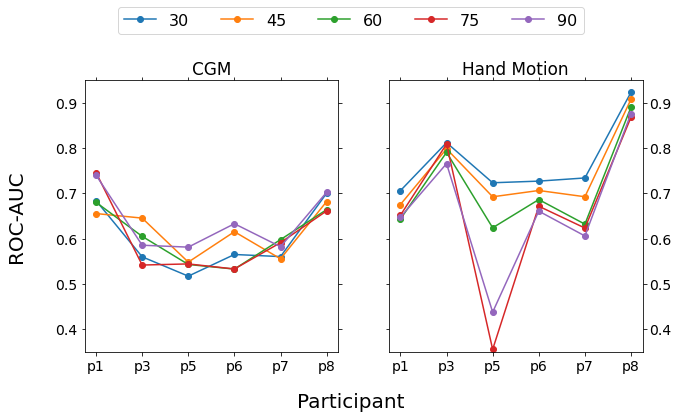

In [6]:
sensors=['CGM']
fig,ax =  plt.subplots(1,2,figsize=(10,5))
for sensor in sensors:
    dfAnalytics=pd.read_excel('/home/grads/s/sorush.omidvar/STMI-CGM-Predictor/BigWindowAnalytics.xlsx')
    # dfAnalytics=pd.read_excel('/home/grads/s/sorush.omidvar/STMI-CGM-Predictor/SmallWindowAnalytics.xlsx')
    dfAnalytics=dfAnalytics[dfAnalytics['Combination']==sensor]
    xData=dfAnalytics['Participant'].to_list()
    yData=dfAnalytics['ROC-AUC'].to_list()
    for counter in range(5):
        ax[0].plot(xData[0+counter*6:(counter+1)*6],yData[0+counter*6:(counter+1)*6],marker='o')
    ax[0].title.set_text(sensor)
# sensors=['CGM','HR','Motion','Temperature','EDA']
# ax[0].legend(loc='upper center',title="")
# ax[0].get_legend().remove()
ax[0].set_ylim([0.35,0.95])
ax[0].set_xlabel('',fontsize=20)
ax[0].set_ylabel('ROC-AUC',fontsize=20)
ax[0].yaxis.set_label_coords(-0.23, 0.5)
ax[0].tick_params(top=True, right=True)

sensors=['Motion']
for sensor in sensors:
    # dfAnalytics=pd.read_excel('/home/grads/s/sorush.omidvar/STMI-CGM-Predictor/BigWindowAnalytics.xlsx')
    dfAnalytics=pd.read_excel('/home/grads/s/sorush.omidvar/STMI-CGM-Predictor/SmallWindowAnalytics.xlsx')
    dfAnalytics=dfAnalytics[dfAnalytics['Combination']==sensor]
    xData=dfAnalytics['Participant'].to_list()
    yData=dfAnalytics['ROC-AUC'].to_list()
    for counter in range(5):
        ax[1].plot(xData[0+counter*6:(counter+1)*6],yData[0+counter*6:(counter+1)*6],marker='o')
    ax[1].title.set_text('Hand Motion')
    # pd.pivot_table(dfAnalytics.reset_index(),
    #            index='Participant', columns='Window', values='ROC-AUC'
    #           ).plot(subplots=False,title=sensor,ax=ax[1],style='-x')
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_ylim([0.35,0.95])
ax[1].set_xlabel('Participant',fontsize=20)

ax[1].xaxis.set_label_coords(-0.15, -0.15)
ax[1].legend([30,45,60,75,90],loc='upper center', bbox_to_anchor=(-0.15, 1.3),ncol=5,fontsize=16)
ax[1].tick_params(top=True, left=True)

fig.savefig(os.path.join(addDataPrefix,'Results0-UserEnd','WindowSize.png'),dpi=1200, bbox_inches='tight')

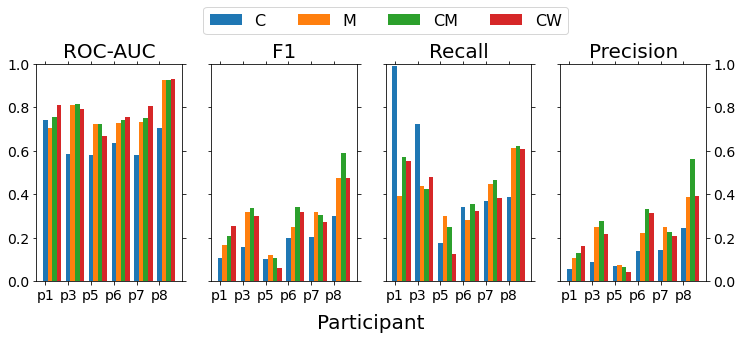

In [29]:
dfAnalytics=pd.read_excel('/home/grads/s/sorush.omidvar/CGMDataset/TAMU/Results0-UserEnd/0:30:00-0:00:30-Final-Classifier.xlsx')
dfAnalytics.sort_values(["Combination","Participant"], ascending=(True, True), inplace=True)

sensors=['CGM','Motion','Motion+CGM','Motion+CGM+EDA+HR+Temperature']
fig,ax =  plt.subplots(1,4,figsize=(12,4))

for counter in range(len(sensors)):
    dfTemp=dfAnalytics[dfAnalytics['Combination']==sensors[counter]]
    xData=np.arange(6)+0.2*counter
    yData=dfTemp['ROC-AUC'].to_list()
    ax[0].bar(xData,yData,0.2)
xData=dfTemp['Participant'].to_list()
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels(xData)
# ax[0].set_ylabel('R',fontsize=20)
ax[0].set_title('ROC-AUC',fontsize=20)
# ax[0].yaxis.set_label_coords(-0.2, 0.5)
ax[0].set_ylim([0,1])
ax[0].tick_params(top=True, right=True)


for counter in range(len(sensors)):
    dfTemp=dfAnalytics[dfAnalytics['Combination']==sensors[counter]]
    xData=np.arange(6)+0.2*counter
    yData=dfTemp['F1'].to_list()
    ax[1].bar(xData,yData,0.2)
xData=dfTemp['Participant'].to_list()
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels(xData)
ax[1].set_yticklabels('')
ax[1].set_title('F1',fontsize=20)
ax[1].set_ylim([0,1])
ax[1].tick_params(top=True, right=True)



for counter in range(len(sensors)):
    dfTemp=dfAnalytics[dfAnalytics['Combination']==sensors[counter]]
    xData=np.arange(6)+0.2*counter
    yData=dfTemp['Recall'].to_list()
    ax[2].bar(xData,yData,0.2)
xData=dfTemp['Participant'].to_list()
ax[2].set_xticks([0,1,2,3,4,5])
ax[2].set_xticklabels(xData)
ax[2].set_yticklabels('')
# ax[1].set_ylabel('Recall',fontsize=20)
# ax[1].yaxis.set_label_coords(-0.2, 0.5)
ax[2].set_title('Recall',fontsize=20)
ax[2].legend(['C','H','CH','CHE'],loc='upper center', bbox_to_anchor=(0, 1.3),ncol=4,fontsize=16)
ax[2].set_ylim([0,1])
ax[2].tick_params(top=True, right=True)



for counter in range(len(sensors)):
    dfTemp=dfAnalytics[dfAnalytics['Combination']==sensors[counter]]
    xData=np.arange(6)+0.2*counter
    yData=dfTemp['Precision'].to_list()
    ax[3].bar(xData,yData,0.2)
xData=dfTemp['Participant'].to_list()
ax[3].set_xticks([0,1,2,3,4,5])
ax[3].set_xticklabels(xData)
# ax[2].set_ylabel('Precision',fontsize=20)
# ax[2].yaxis.set_label_coords(1.2, 0.5)
ax[3].set_xlabel('Participant',fontsize=20)
ax[3].xaxis.set_label_coords(-1.3, -0.15)
ax[3].set_title('Precision',fontsize=20)
ax[3].set_ylim([0,1])
ax[3].yaxis.set_label_position("right")
ax[3].yaxis.tick_right()
ax[3].tick_params(top=True, left=True)

fig.savefig(os.path.join(addDataPrefix,'Results0-UserEnd','ModelResults.png'),dpi=1200, bbox_inches='tight')